In [139]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
import catboost as catb

In [140]:
import warnings
warnings.simplefilter('ignore')

## Пути к директориям и файлам

In [141]:
dataset_path = "train.csv"
prep_dataset_path = "test.csv"

In [142]:
df = pd.read_csv(dataset_path)
test = pd.read_csv(prep_dataset_path)
train = pd.read_csv(dataset_path)

## Описание данных

#####    Home Ownership - домовладение
#####    Annual Income - годовой доход
#####    Years in current job - количество лет на текущем месте работы
#####    Tax Liens - налоговые обременения
#####    Number of Open Accounts - количество открытых счетов
#####    Years of Credit History - количество лет кредитной истории
#####    Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
#####    Number of Credit Problems - количество проблем с кредитом
#####    Months since last delinquent - количество месяцев с последней просрочки платежа
#####    Bankruptcies - банкротства
#####    Purpose - цель кредита
#####    Term - срок кредита
#####    Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
#####    Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
#####    Monthly Debt - ежемесячный долг
#####    Credit Score - баллы кредитного рейтинга
#####    Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


## Приведение типов

**Years in current job**

перевод в вещественный признак

In [143]:
train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [144]:
def years_in_current_job_to_cat(data):
    data['Years in current job'] = data['Years in current job'].map({'< 1 year': 0,
                                                                 '1 year': 1,
                                                                 '2 years': 2,
                                                                 '3 years': 3,
                                                                 '4 years': 4,
                                                                 '5 years': 5,
                                                                 '6 years': 6,
                                                                 '7 years': 7,
                                                                 '8 years': 8,
                                                                 '9 years': 9,
                                                                 '10+ years': 10
                                                                })
    return data

In [145]:
df = years_in_current_job_to_cat(df)
train = years_in_current_job_to_cat(train)
test = years_in_current_job_to_cat(test)

In [146]:
df.shape

(7500, 17)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

## Обзор данных

### Обзор целевой переменной

In [148]:
df["Credit Default"].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Обзор количественных признаков

In [149]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7129.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,5.880348,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,3.620092,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


наблюдаются аномалии в следующих признаках:

- Maximum Open Credit
- Current Loan Amount
- Credit Score


### Обзор номинативных признаков

- Home Ownership - домовладение
- Years in current job - количество лет на текущем месте работы
- Purpose - цель кредита
- Term - срок кредита

In [150]:
for cat_colname in df.select_dtypes(include="object").columns:
    print(f'{cat_colname}' + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



- изучить объединение в Home Ownership;
- изучить объединение в Purpose;
- изучить объединение в Years in Current job;

## Обработка данных

отсутствует часть данных в:
    
    - Annual income;
    - Years in current job;
    - Month since last delinquent;
    - Bankruptcies;
    - Credit Score

### Заполнение пропусков

**Annual Income**

In [151]:
annual_income_median = df["Annual Income"].median()

def annual_income_fillna(data):
    data['Annual Income NaN'] = False
    data.loc[data["Annual Income"].isna(), "Annual Income NaN"] = True
    data.loc[data["Annual Income"].isna(), "Annual Income"] =  annual_income_median # замена пропусков годового дохода на медиану
    return data

df = annual_income_fillna(df)
train = annual_income_fillna(train)
test = annual_income_fillna(test)

**Years in current job**

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [153]:
years_in_current_job_mode = train["Years in current job"].mode()[0]

In [154]:
years_in_current_job_mode = train["Years in current job"].mode()[0]

def years_in_current_job_fillna(data):
    data['Years in current job NaN'] = False
    data.loc[data["Years in current job"].isna(), "Years in current job NaN"] = True
    data.loc[data["Years in current job"].isna(), "Years in current job"] = years_in_current_job_mode
    return data

df = years_in_current_job_fillna(df)
train = years_in_current_job_fillna(train)
test = years_in_current_job_fillna(test)

**Months since last delinquent**

In [155]:
months_since_last_delinquent_median = train["Months since last delinquent"].median()

def months_since_last_delinquent_fillna(data):
    data['Months since last delinquent NaN'] = False
    data.loc[data["Months since last delinquent"].isna(), "Months since last delinquent NaN"] = True
    data.loc[data["Months since last delinquent"].isna(), "Months since last delinquent"] = months_since_last_delinquent_median
    return data


df = months_since_last_delinquent_fillna(df)
train = months_since_last_delinquent_fillna(train)
test = months_since_last_delinquent_fillna(test)

**Bankruptcies**

In [156]:
bankruptcies_median = train["Bankruptcies"].median()

def bankruptcies_fillna(data):
    data.loc[data["Bankruptcies"].isna(), "Bankruptcies"] = bankruptcies_median
    return data


df = bankruptcies_fillna(df)
train = bankruptcies_fillna(train)
test = bankruptcies_fillna(test)

**Credit Score**

In [157]:
credit_score_median = train['Credit Score'].median()

def credit_score_fillna(data):
    data['Credit Score NaN'] = False
    data.loc[data['Credit Score'].isna(), 'Credit Score NaN'] = True
    data.loc[data["Credit Score"].isna(), "Credit Score"] = credit_score_median
    return data

df = credit_score_fillna(df)
train = credit_score_fillna(train)
test = credit_score_fillna(test)

*Проверка заполененности*

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Home Ownership                    7500 non-null   object 
 1   Annual Income                     7500 non-null   float64
 2   Years in current job              7500 non-null   float64
 3   Tax Liens                         7500 non-null   float64
 4   Number of Open Accounts           7500 non-null   float64
 5   Years of Credit History           7500 non-null   float64
 6   Maximum Open Credit               7500 non-null   float64
 7   Number of Credit Problems         7500 non-null   float64
 8   Months since last delinquent      7500 non-null   float64
 9   Bankruptcies                      7500 non-null   float64
 10  Purpose                           7500 non-null   object 
 11  Term                              7500 non-null   object 
 12  Curren

### Обработка выбросов

In [159]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,6.084133,0.030133,11.130933,18.317467,9.451537e+05,0.170000,33.227467,0.116933,1.187318e+07,2.898332e+05,18314.454133,1063.877333,0.281733
std,7.567551e+05,3.640717,0.271604,4.908924,7.041946,1.602622e+07,0.498598,14.703950,0.346904,3.192612e+07,3.178714e+05,11926.764673,1438.335832,0.449874
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,32.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Maximum Open Credit**

<AxesSubplot:xlabel='Maximum Open Credit'>

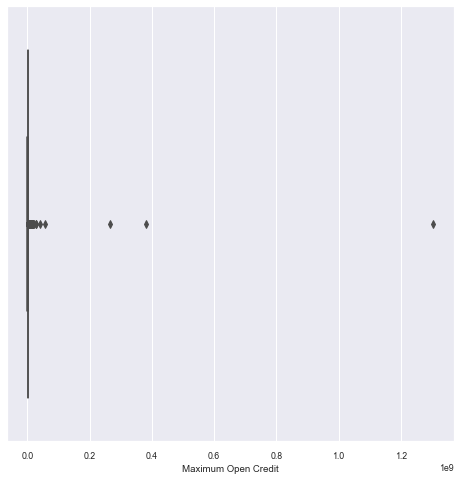

In [160]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=df,
           x="Maximum Open Credit")

<AxesSubplot:>

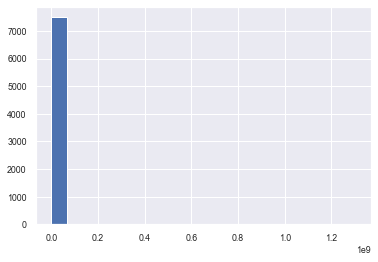

In [161]:
df['Maximum Open Credit'].hist(bins=20)

In [162]:
maximum_open_credit_max = train["Maximum Open Credit"].quantile(0.95)

def maximum_open_credit(data):
    data['Maximum Open Credit outlier'] = False
    data.loc[data["Maximum Open Credit"] > 2 * 10 ** 8, 'Maximum Open Credit outlier'] = True
    data.loc[data["Maximum Open Credit"] > 2 * 10 ** 8, "Maximum Open Credit"] = maximum_open_credit_max
    return data

df = maximum_open_credit(df)
train = maximum_open_credit(train)
test = maximum_open_credit(test)

<AxesSubplot:xlabel='Maximum Open Credit'>

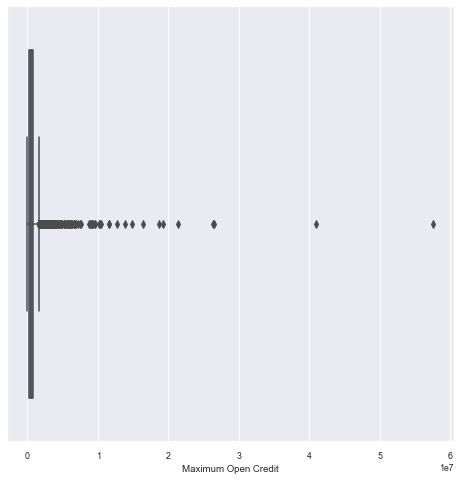

In [163]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=df,
           x="Maximum Open Credit")

**Current Loan Amount**

<AxesSubplot:xlabel='Current Loan Amount', ylabel='Density'>

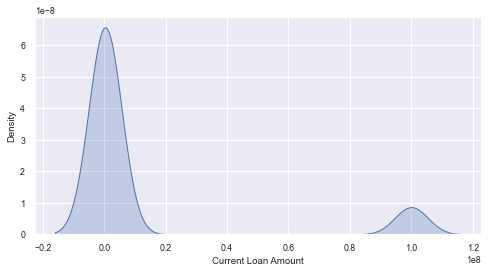

In [164]:
plt.figure(figsize=(8, 4))
sns.kdeplot(x=df["Current Loan Amount"], shade=True)

In [165]:
current_loan_median = train["Current Loan Amount"].max()

def current_loan_amount(data):
    data['Current Loan Amount outlier'] = False
    data.loc[data["Current Loan Amount"] > 0.2 * 10 ** 8, 'Current Loan Amount outlier'] = True
    data.loc[data["Current Loan Amount"] > 0.2 * 10 ** 8, "Current Loan Amount"] = current_loan_median
    return(data)


df = current_loan_amount(df)
train = current_loan_amount(train)
test = current_loan_amount(test)

<AxesSubplot:xlabel='Current Loan Amount', ylabel='Density'>

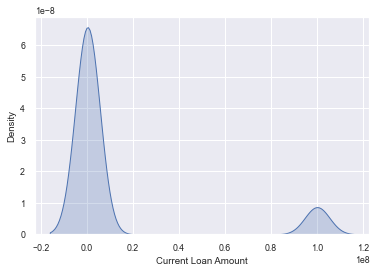

In [166]:
sns.kdeplot(data=df["Current Loan Amount"], shade=True)

**Credit Score**

<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

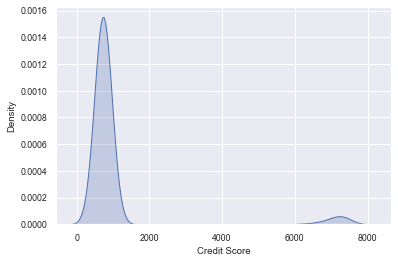

In [167]:
sns.kdeplot(x=df["Credit Score"], shade=True)

In [168]:
credit_score_median = df['Credit Score'].median()

def credit_score(data):
    data['Credit Score outlier'] = False
    data.loc[data['Credit Score'] > 1500, 'Credit Score outlier'] = True
    data.loc[data["Credit Score"] > 1500, "Credit Score"] = credit_score_median
    return data


df = credit_score(df)
train = credit_score(train)
test = credit_score(test)

<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

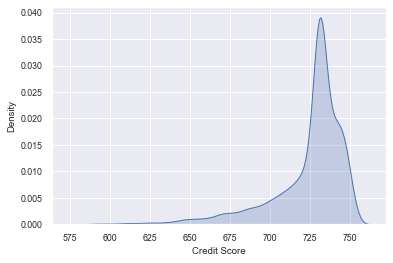

In [169]:
sns.kdeplot(x=df["Credit Score"], shade=True)

**Number of credit problems and Tax Liens**

<AxesSubplot:xlabel='Number of Credit Problems', ylabel='Credit Default'>

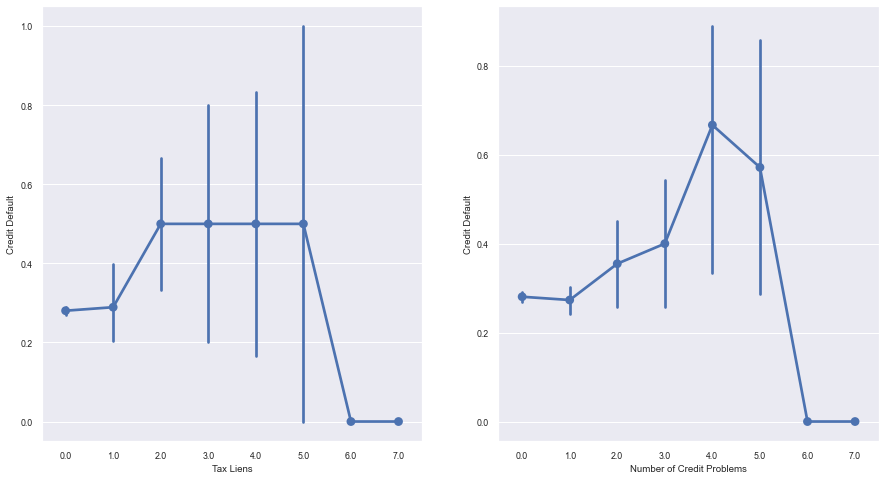

In [170]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
sns.pointplot(data=df, x='Tax Liens', y='Credit Default')
plt.subplot(122)
sns.pointplot(data=df, x='Number of Credit Problems', y='Credit Default')

In [171]:
df.loc[df['Number of Credit Problems'] >= 5, ['Tax Liens', 'Credit Default']].count()

Tax Liens         12
Credit Default    12
dtype: int64

In [172]:
df.loc[df['Tax Liens'] >= 5, ['Tax Liens', 'Credit Default']].count()

Tax Liens         5
Credit Default    5
dtype: int64

In [173]:
def drop_number_of_credit_problems(data):
    data.loc[data['Number of Credit Problems'] >= 5, ['Number of Credit Problems', 'Tax Liens']] = 0
    return data

df = drop_number_of_credit_problems(df)
train = drop_number_of_credit_problems(train)
test = drop_number_of_credit_problems(test)

In [174]:
# def drop_number_of_credit_problems(data):
#     data = data.drop(index=data.loc[data['Number of Credit Problems'] >= 5].index)
#     return data

# df = drop_number_of_credit_problems(df)
# train = drop_number_of_credit_problems(train)
# test = drop_number_of_credit_problems(test)

### Выделение целевой переменной и групп признаков

In [175]:
df_base = pd.read_csv("train.csv")

In [176]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).to_list()

In [177]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [178]:
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [179]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

**Корреляция с базовыми признаками**

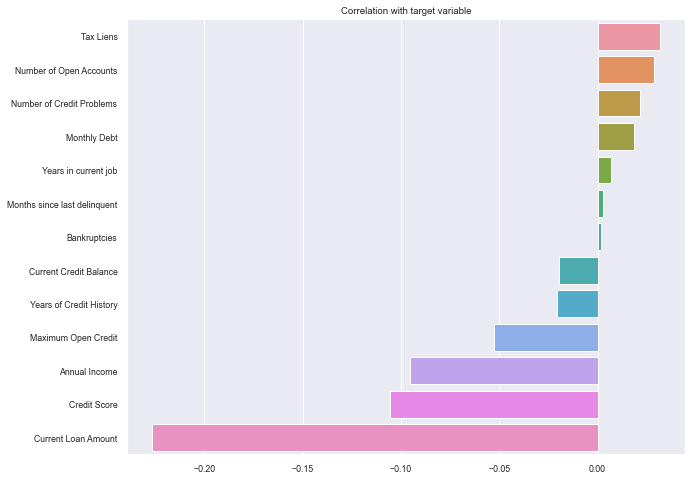

In [180]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Оценка "Credit Score" в разрезе целевой переменной**

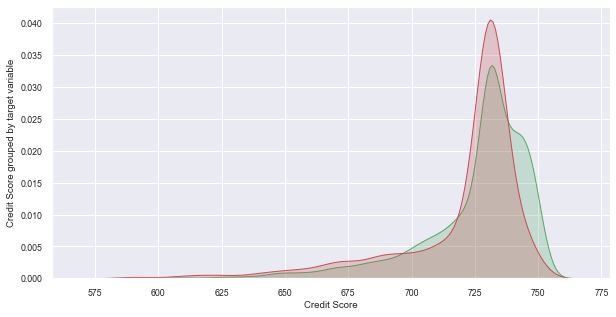

In [181]:
credit_score_with_target = df[['Credit Score', TARGET_NAME]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[TARGET_NAME] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.ylabel('Credit Score grouped by target variable')
plt.show()

группы имеют различные распределения, возможно существует некая функциональная зависимость

**Гипотеза**
- Н0 - средние значения в двух независимых выборках равны
- Н1 - средние значения в двух независмых выборках различаются
- Критерий: критерий Стьюдента (t-тест) и его аналоги
- Уровень значимости: 0.05

In [182]:
stats.shapiro(credit_score)

ShapiroResult(statistic=0.7849956750869751, pvalue=0.0)

при проведении теста Шапиро-Уилка выяснилось, что распределение признака не является нормальным: p-value < 0.05

Для достоверности произведенм визуальную оценку распределения признака, а также построим QQ-график

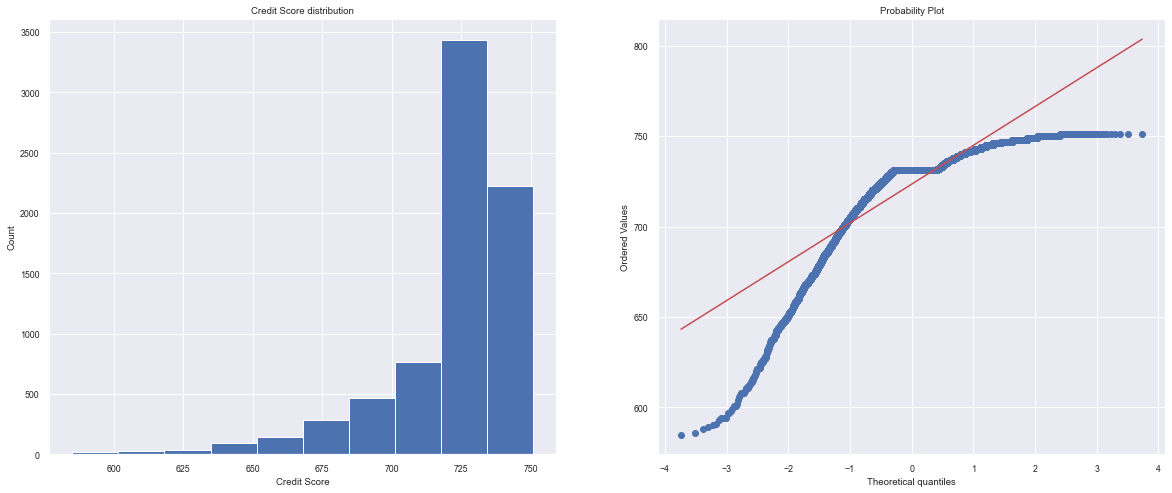

In [183]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score.hist()

plt.subplot(122)
stats.probplot(credit_score, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает, что распределение признака "Credit Score" не является нормальным, следовательно критерий t-Стьюдента использовать не можем.

Оценим эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни

In [184]:
stats.mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=6658423.5, pvalue=4.9379356082723915e-31)

Согласно значению p-value мы видим, что равность мат. ожиданий отвергается p-value < 0.05.

Проверим равность мат. ожиданий согласно построению доверительных интервалов.

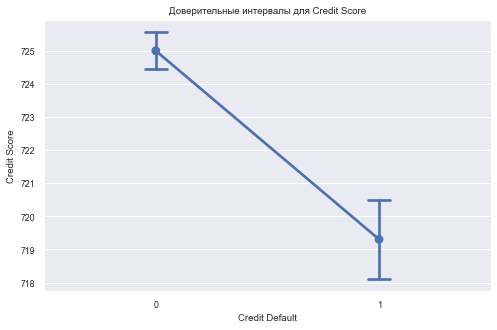

In [185]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target, capsize=.1)

plt.title('Доверительные интервалы для Credit Score')
plt.show()

Данный признак можно использовать в модели

### Матрица корреляций

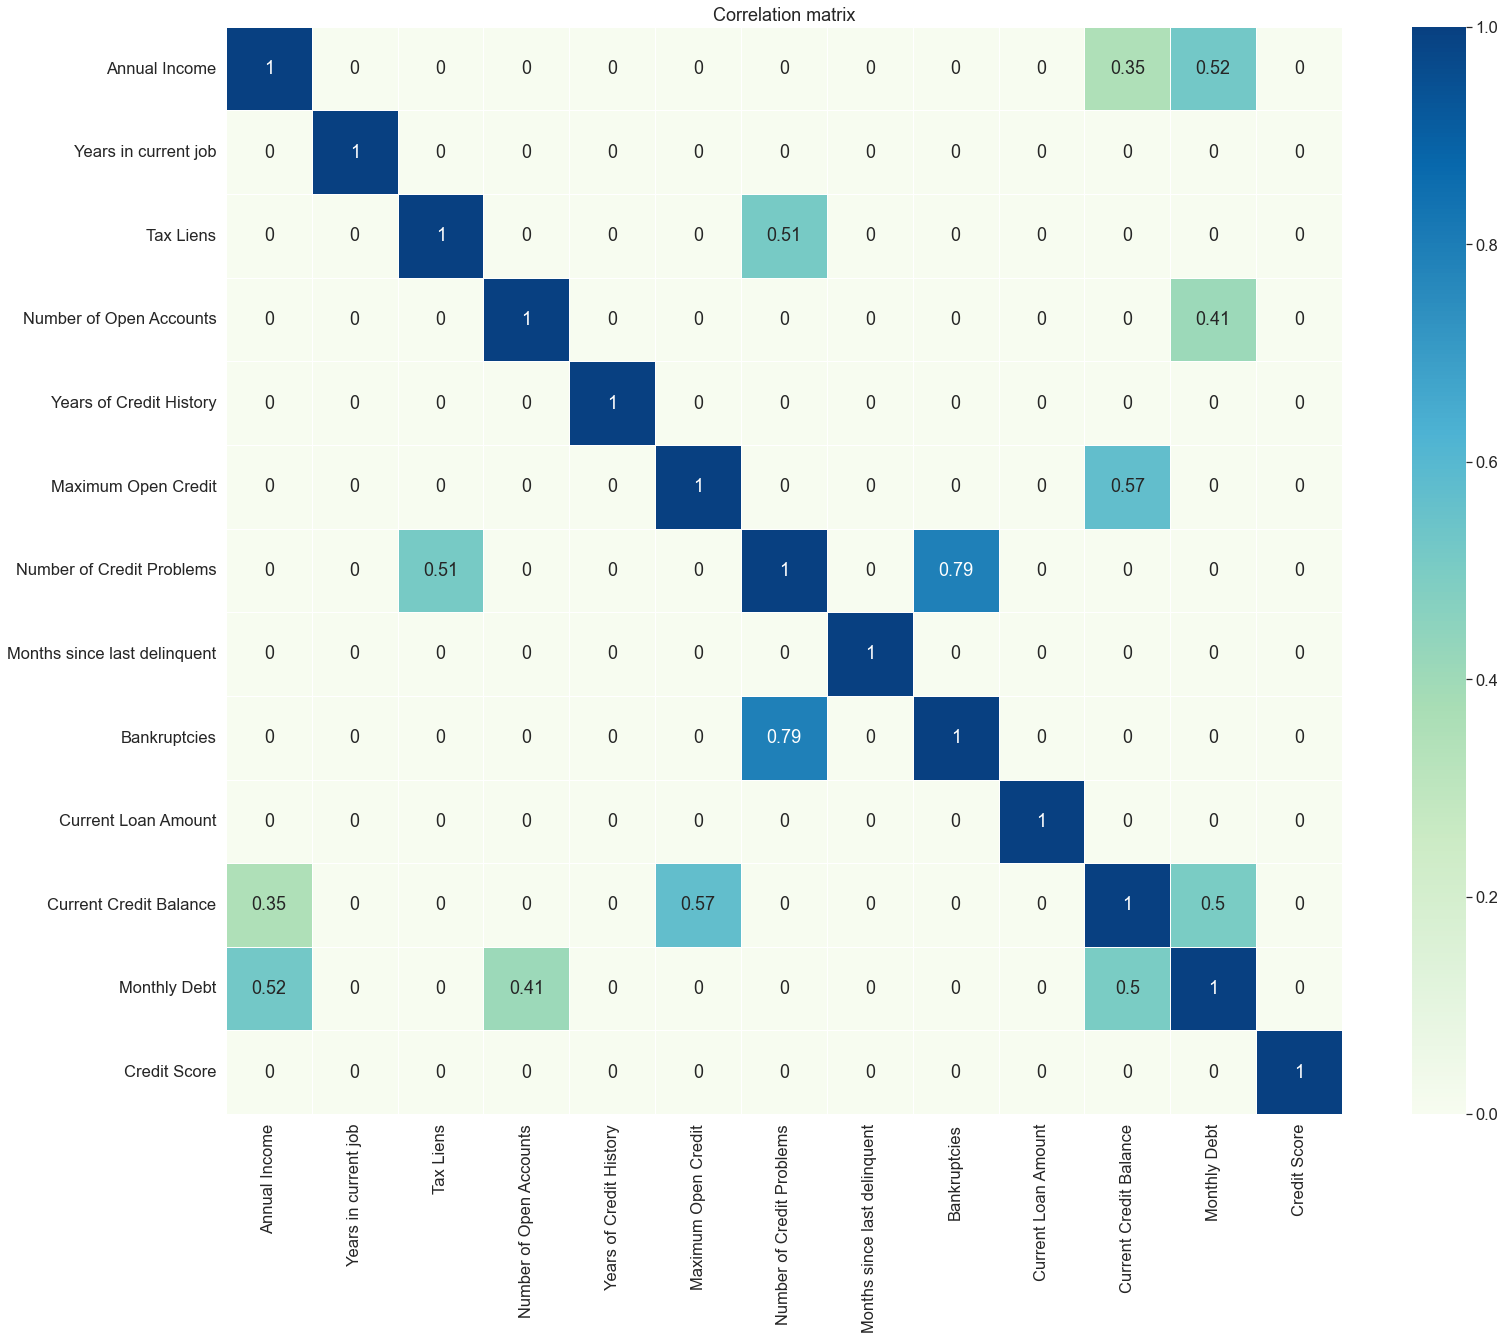

In [186]:
plt.figure(figsize=(25, 20))

sns.set(font_scale=1.5)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [187]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Annual Income NaN',
       'Years in current job NaN', 'Months since last delinquent NaN',
       'Credit Score NaN', 'Maximum Open Credit outlier',
       'Current Loan Amount outlier', 'Credit Score outlier'],
      dtype='object')

In [188]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Проверка распределений вещественных признаков на трейне и тесте**

Annual Income
MannwhitneyuResult(statistic=9361624.5, pvalue=0.9144137159274787)


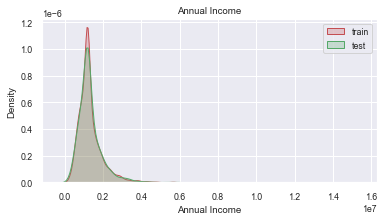

Tax Liens
MannwhitneyuResult(statistic=9340712.0, pvalue=0.22847963661956416)


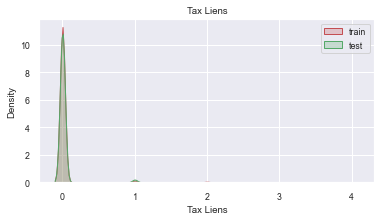

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.4428527435772891)


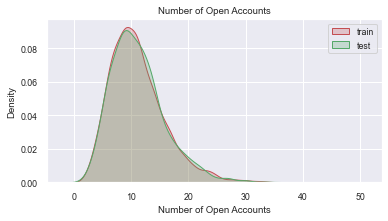

Years of Credit History
MannwhitneyuResult(statistic=9410342.0, pvalue=0.7773891904970164)


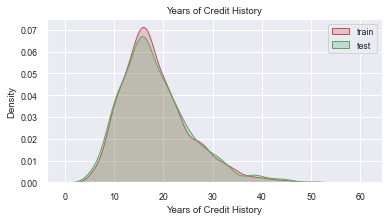

Maximum Open Credit
MannwhitneyuResult(statistic=9337473.0, pvalue=0.7640268433897663)


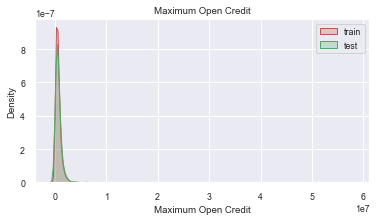

Number of Credit Problems
MannwhitneyuResult(statistic=9463143.0, pvalue=0.2320285609819398)


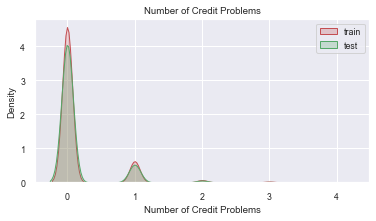

Months since last delinquent
MannwhitneyuResult(statistic=9547189.5, pvalue=0.13134188290466997)


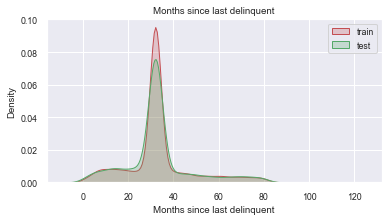

Bankruptcies
MannwhitneyuResult(statistic=9489027.0, pvalue=0.08865901039522157)


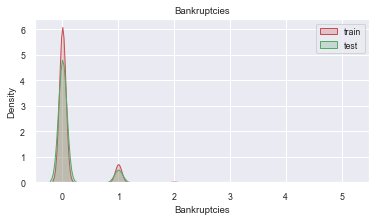

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.24634871937364122)


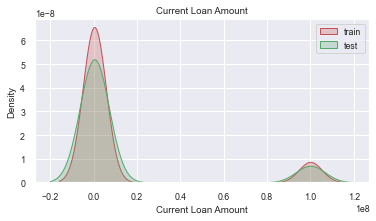

Current Credit Balance
MannwhitneyuResult(statistic=9415950.0, pvalue=0.7432294982728612)


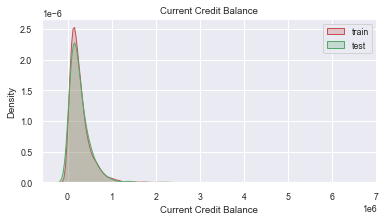

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.48739046661346275)


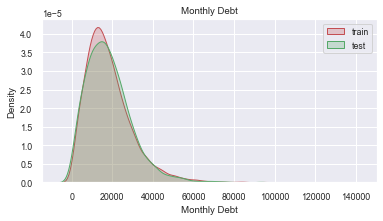

Credit Score
MannwhitneyuResult(statistic=9502581.5, pvalue=0.3022856309776133)


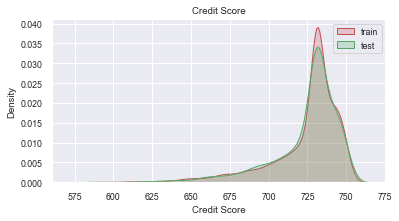

In [189]:

for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=(6, 3))
    sns.set(font_scale=0.8)
    sns.kdeplot(train[col], shade=True, label='train', color='r')
    sns.kdeplot(test[col], shade=True, label='test', color='g')
    print(col)
    print(stats.mannwhitneyu(train[col], test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

При сравнении мат. ожиданий признаков между train и test больших отклонений (pvalue < 0.05) не выявлено.

**Проверка распределений категориальных признаков на трейне и тесте**

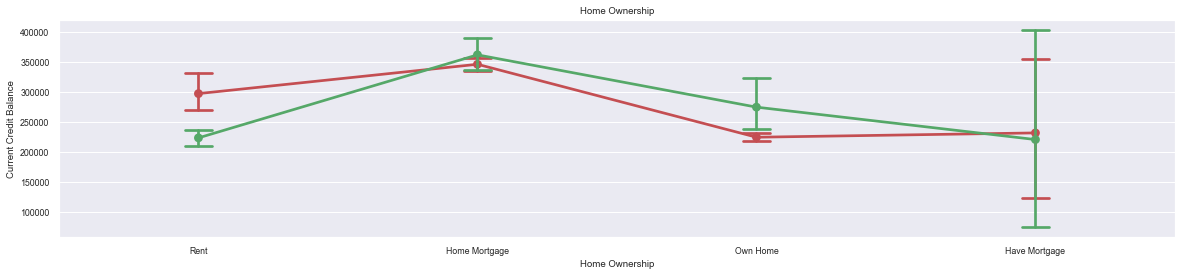

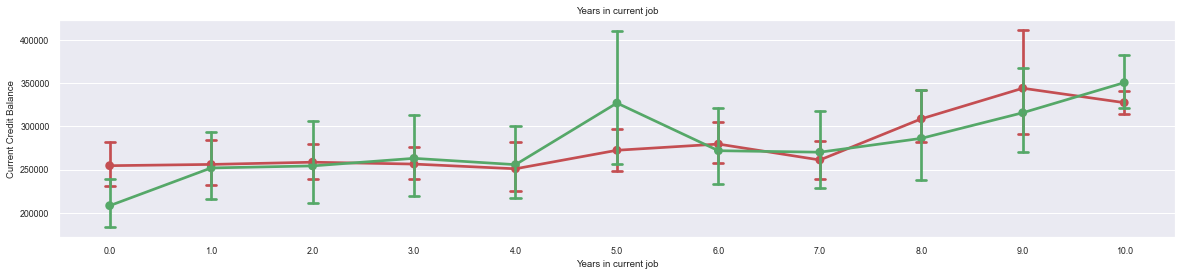

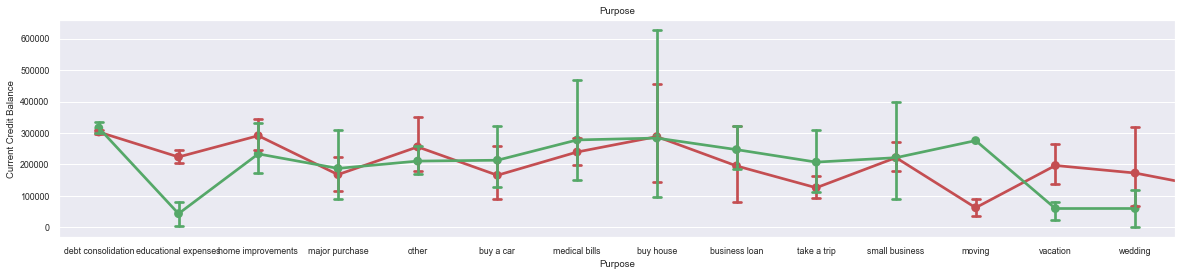

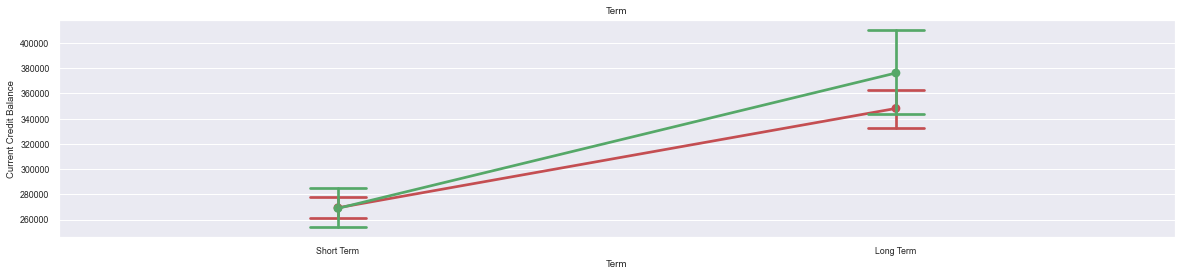

In [190]:
num_feature = 'Current Credit Balance'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(20, 4))
    sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

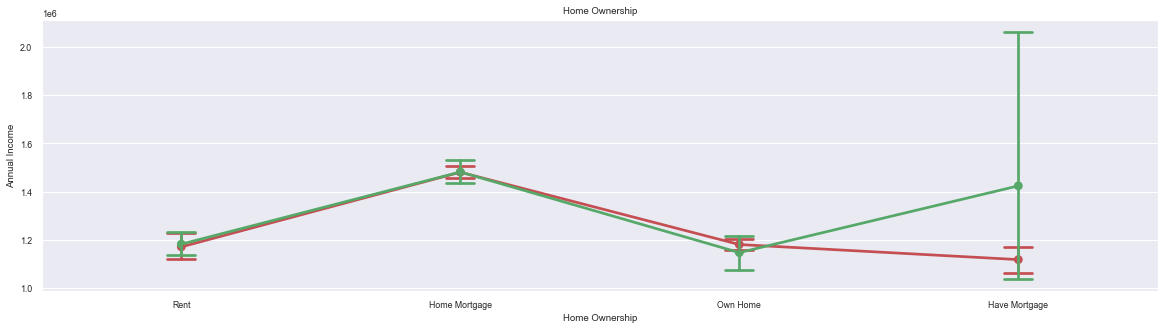

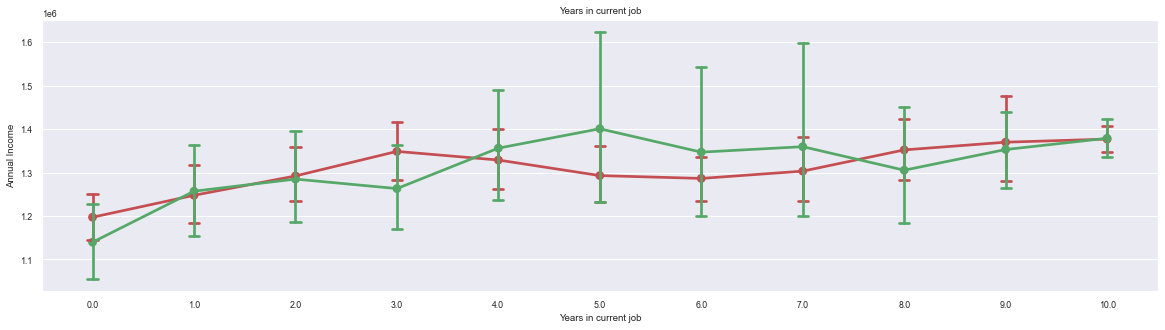

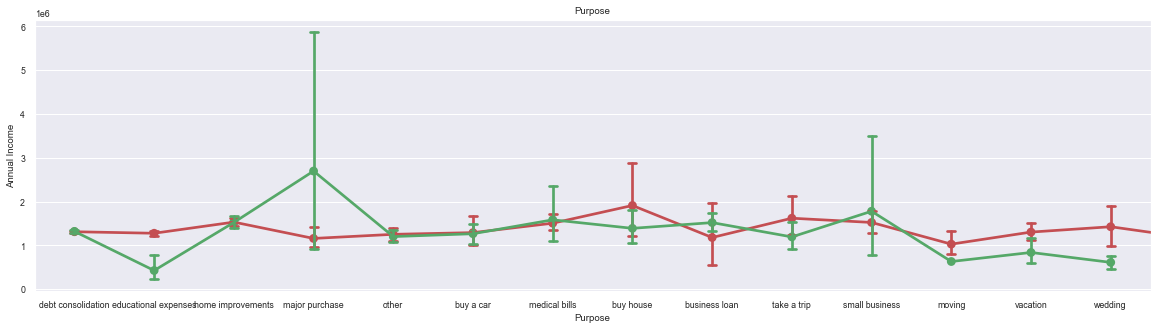

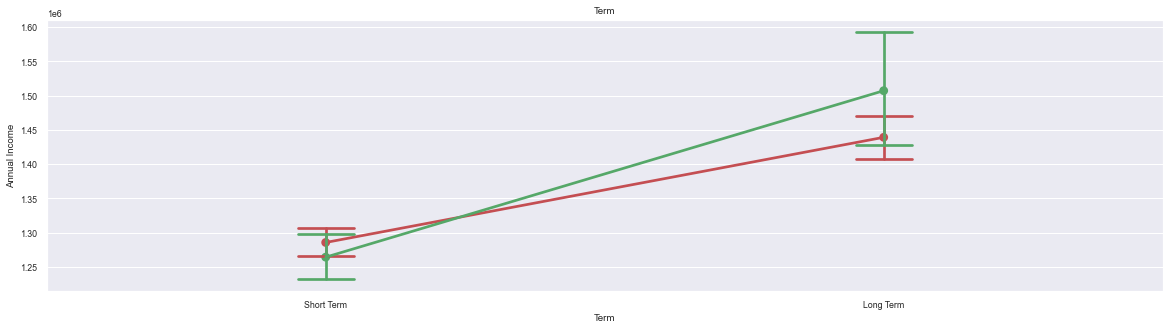

In [191]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(20, 5))
    sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

In [192]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

В признаке 'Purpose' есть признаки, в которых сильно отличаются значения трэйна от теста 'moving', 'renewable energy'

In [193]:
df.loc[df['Purpose'].isin(['moving', 'renewable energy', 'educational expenses']), 'Purpose'] = 'other'

In [194]:
def del_columns_purpose(data):
    df.loc[df['Purpose'].isin(['moving', 'renewable energy', 'educational expenses']), 'Purpose'] = 'other'
    return data

df = del_columns_purpose(df)
train = del_columns_purpose(train)
test = del_columns_purpose(test)

In [195]:
# def del_columns_purpose(data):
#     data = data.drop(index=data.loc[data['Purpose'].isin(['moving', 'renewable energy', 'educational expenses'])].index)
#     return data

# df = del_columns_purpose(df)
# train = del_columns_purpose(train)
# test = del_columns_purpose(test)

## Сокращение количества значений в признаках

**Home Ownership**

In [196]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

рассмотрим возможность объединение Home Mortgage и Have Mortgage

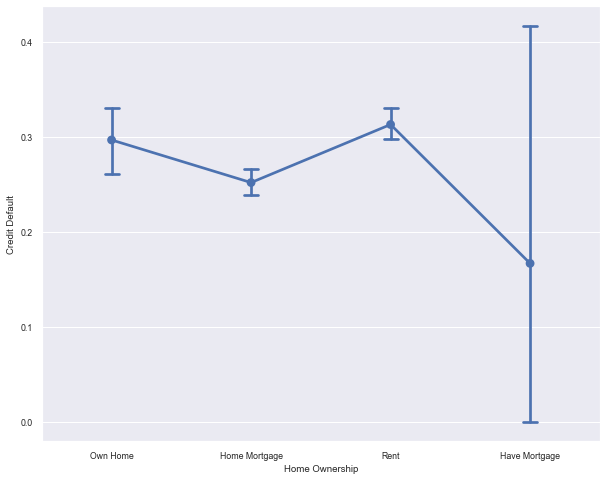

In [197]:
plt.figure(figsize=(10, 8))

sns.pointplot(x="Home Ownership", y="Credit Default", data=df, capsize=.1)

plt.show()

на графике доверительных интервалов однозначного ответа не видно, проверим статистическую гипотезу о согласованности частот методом Хи-квадрат.

- H0 - частоты согласованы
- H1 - частоты не согласованы

In [198]:
df["Id"] = df.index

Home_Ownership_and_target = df.loc[df["Home Ownership"].isin(["Have Mortgage", "Home Mortgage"]), \
                                   ["Id", "Home Ownership", "Credit Default"]]

In [199]:
table = Home_Ownership_and_target.pivot_table(values="Id", index="Home Ownership", columns="Credit Default", aggfunc="count")
table

Credit Default,0,1
Home Ownership,,
Have Mortgage,10,2
Home Mortgage,2721,916


In [200]:
chi2, p, _, _ = stats.chi2_contingency(table)
p

0.7295033251987646

Н0 верна, значит можно объединить

*Объединение* 

In [201]:
def change_home_ownership(data):
    data.loc[data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    return data

df = change_home_ownership(df)
test = change_home_ownership(test)
train = change_home_ownership(train)

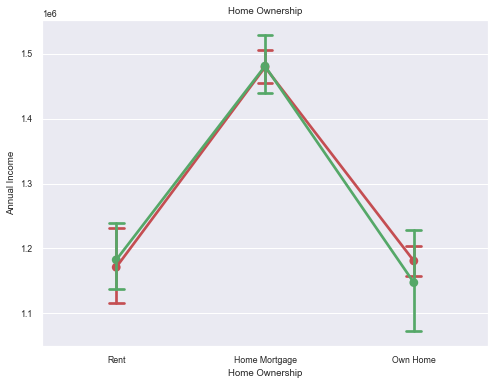

In [202]:
num_feature = 'Annual Income'
col = "Home Ownership"
plt.figure(figsize=(8, 6))
sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label='train', color='r')
sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label='test', color='g')
plt.title(col)
plt.show()

In [203]:
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

**Purpose**

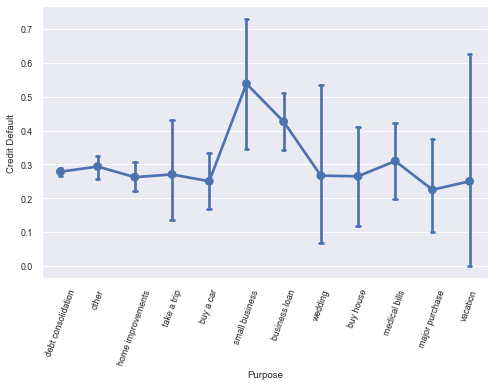

In [204]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Purpose', y=TARGET_NAME, data=df, capsize=.1)
plt.xticks(rotation=70)

plt.show()

In [205]:
def change_purpose(data):
    data.loc[data['Purpose'].isin(['debt consolidation', 'wedding', 'major purchase', 'vacation', 'other', 'home improvements', 'take a trip', 'buy a car', 'buy house', 'medical bills']), 'Purpose'] = 'debt consolidation'
    data.loc[data['Purpose'].isin(['small business', 'business loan']), 'Purpose'] = 'business'
    return data

df = change_purpose(df)
train = change_purpose(train)
test = change_purpose(test)

In [206]:
df['Purpose'].value_counts()

debt consolidation    7345
business               155
Name: Purpose, dtype: int64

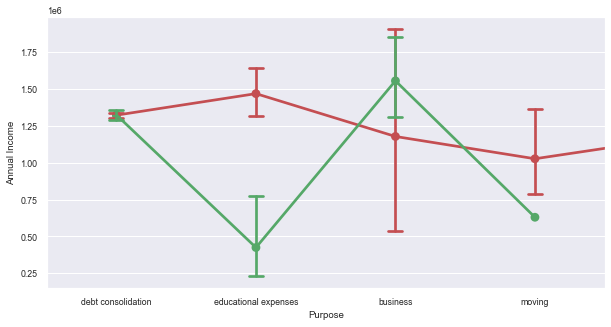

In [207]:
num_feature = 'Annual Income'
col = 'Purpose'
plt.figure(figsize=(10, 5))
sns.pointplot(x=col, y=num_feature, data=train, capsize=.1, label=train, color='r')
sns.pointplot(x=col, y=num_feature, data=test, capsize=.1, label=test, color='g')
plt.show()

## Создание новых признаков

Варианты генерации новых признаков:
1. Категориальные признаки
    - порядковые числа
    - создание бинарных переменных
    - feature encoding
    - target encoding
2. Вещественные признаки
    - Feature discretization
    - Feature binarization
3. Генерация фичей исходя из логики
4. Автоматическая генерация фичей

### Категориальные признаки

### Создание бинарных переменных

**Home Ownership**

Создание бинарных признаков Home Ownership и объединение с основной датой

In [208]:
def home_dummies(data):
    data_home = pd.get_dummies(data["Home Ownership"]).astype(bool)
    data = pd.concat([data, data_home], axis=1)
    return data

In [209]:
df = home_dummies(df)
train = home_dummies(train)
test = home_dummies(test)

**Term**

создание новых бинарных признаков

In [210]:
def term_dummies(data):
    data_term = pd.get_dummies(data["Term"]).astype(bool)
    data = pd.concat([data, data_term], axis=1)
    return data

In [211]:
df = term_dummies(df)
train = term_dummies(train)
test = term_dummies(test)

**Purpose**

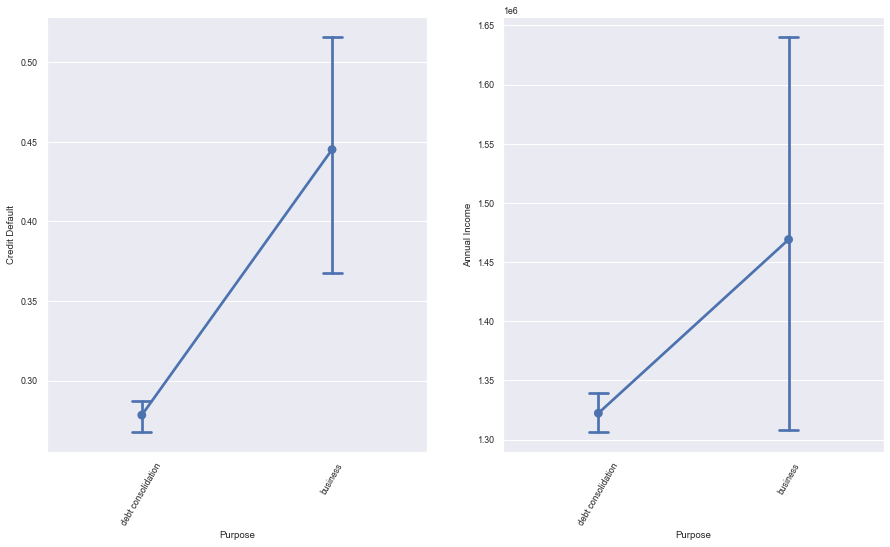

In [212]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
ax1 = sns.pointplot(x='Purpose', y='Credit Default', data=df, capsize=.1)
plt.xticks(rotation=60)
plt.subplot(122)
ax1 = sns.pointplot(x='Purpose', y='Annual Income', data=df, capsize=.1)
plt.xticks(rotation=60)
plt.show()

In [213]:
def purpose_dummies(data):
    data_purpose = pd.get_dummies(data["Purpose"]).astype(bool)
    data = pd.concat([data, data_purpose], axis=1)
    return data

In [214]:
df = purpose_dummies(df)
train = purpose_dummies(train)
test = purpose_dummies(test)

### Feature encoding

Не обнаружено категориальных признаков, коррелирующих между собой.

### Target encoding

**Term**

In [215]:
df_cat = df.groupby('Term', as_index=False).mean()[['Term', 'Credit Default']].rename(
    columns={'Credit Default': 'target_encode_term'})

df_cat

,Term,target_encode_term
0,Long Term,0.419753
1,Short Term,0.233441


In [216]:
df = df.merge(df_cat, on='Term', how='left')
train = train.merge(df_cat, on='Term', how='left')
test = test.merge(df_cat, on='Term', how='left')

**Home Ownership**

In [217]:
df_cat = df.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(
    columns={'Credit Default': 'target_encode_years_in_current_job'})
df_cat

,Home Ownership,target_encode_years_in_current_job
0,Home Mortgage,0.251576
1,Own Home,0.296754
2,Rent,0.313046


In [218]:
df = df.merge(df_cat, on='Home Ownership', how='left')
train = train.merge(df_cat, on='Home Ownership', how='left')
test = test.merge(df_cat, on='Home Ownership', how='left')

### Вещественные признаки

**1) Feature discretization**

не найдено признаков, из которых можно создать категориальные.

**2) Feature binarization**

In [219]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id,target_encode_term,target_encode_years_in_current_job
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,6.084133,0.024133,11.130933,18.317467,6.857974e+05,0.161200,33.227467,0.116933,1.187318e+07,2.898332e+05,18314.454133,723.392000,0.281733,3749.500000,0.281733,0.281733
std,7.567551e+05,3.640717,0.206777,4.908924,7.041946,1.263641e+06,0.449935,14.703950,0.346904,3.192612e+07,3.178714e+05,11926.764673,24.196917,0.449874,2165.207842,0.081646,0.029681
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.233441,0.251576
25%,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000,1874.750000,0.233441,0.251576
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000,3749.500000,0.233441,0.296754
75%,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,32.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,738.000000,1.000000,5624.250000,0.419753,0.313046
max,1.014934e+07,10.000000,4.000000,43.000000,57.700000,5.756256e+07,4.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,751.000000,1.000000,7499.000000,0.419753,0.313046


**Annual Income**

<AxesSubplot:xlabel='Credit Default', ylabel='Annual Income'>

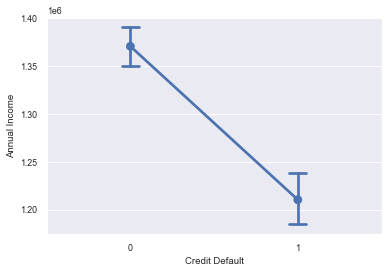

In [220]:
sns.pointplot(data=df, x='Credit Default', y='Annual Income', capsize=.1)

In [221]:
def small_annual_income(data):
    data['small_annual_income'] = (data['Annual Income'] < 1.3 * 10**6).astype('bool')
    return data

In [222]:
df = small_annual_income(df)
train = small_annual_income(train)
test = small_annual_income(test)

**Maximum Open Credit**

<AxesSubplot:xlabel='Credit Default', ylabel='Maximum Open Credit'>

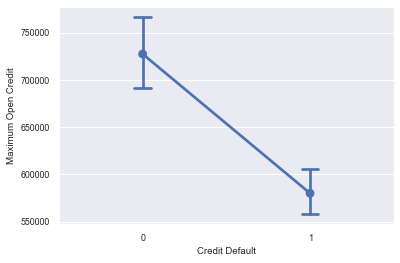

In [223]:
sns.pointplot(data=df, x='Credit Default', y='Maximum Open Credit', capsize=.1)

In [224]:
def small_maximum_open_credit(data):
    data['small_maximum_open_credit'] = (data['Maximum Open Credit'] < 680000).astype('bool')
    return data

In [225]:
df = small_maximum_open_credit(df)
train = small_maximum_open_credit(train)
test = small_maximum_open_credit(test)

In [226]:
train.columns.to_list()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Annual Income NaN',
 'Years in current job NaN',
 'Months since last delinquent NaN',
 'Credit Score NaN',
 'Maximum Open Credit outlier',
 'Current Loan Amount outlier',
 'Credit Score outlier',
 'Home Mortgage',
 'Own Home',
 'Rent',
 'Long Term',
 'Short Term',
 'business',
 'debt consolidation',
 'educational expenses',
 'moving',
 'renewable energy',
 'target_encode_term',
 'target_encode_years_in_current_job',
 'small_annual_income',
 'small_maximum_open_credit']

In [227]:
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [228]:
features = [
    'Annual Income',
    'Annual Income NaN',
#     'Years in current job',
#     'Years in current job NaN',
#     'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
#     'Maximum Open Credit outlier',
    'Number of Credit Problems',
    'Months since last delinquent',
#     'Months since last delinquent NaN',
#     'Bankruptcies',
    'Current Loan Amount',
#     'Current Loan Amount outlier',
    'Current Credit Balance',
#     'Monthly Debt',
    'Credit Score',
     'Credit Score NaN',
#      'Credit Score outlier',
    'Home Mortgage',
    'Own Home',
#     'Rent',
    'Long Term',
#     'Short Term',
    'business',
#     'debt consolidation',
    'target_encode_term',
#     'target_encode_years_in_current_job',
#     'small_annual_income',
#     'small_maximum_open_credit',
]

In [229]:
train_train, train_test = train_test_split(train,
                                           test_size=0.15,
                                           shuffle=True,
                                           stratify=train['Credit Default'],
                                           random_state=1
                                           )

In [230]:
train_train.shape, train_test.shape

((6375, 38), (1125, 38))

In [231]:
X_train = train_train[features + ['Purpose']]
y_train = train_train[TARGET_NAME]

X_test = train_test[features + ['Purpose']]
y_test = train_test[TARGET_NAME]

In [232]:
catb_model = catb.CatBoostClassifier(silent=True, random_state=2,
                                    cat_features=['Purpose']
                                    )

catb_model.fit(X_train, y_train)

pred_train = catb_model.predict(X_train)
pred_test = catb_model.predict(X_test)

print('TRAIN\n', round(metrics.f1_score(y_train, pred_train), 3))
print('TEST\n', round(metrics.f1_score(y_test, pred_test), 3))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

TRAIN
 0.668
TEST
 0.475


TRAIN
 0.668
TEST
 0.506

**Во сколько раз меньший класс меньше большего**

In [233]:
weight_min = df[TARGET_NAME].value_counts()[0]/df[TARGET_NAME].value_counts()[1] - 1
weight_min

1.549455750118315

**Масштабирование данных**

In [234]:
NUM_FEATURES = [
    'Annual Income',
#     'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent',
    'Current Loan Amount',
    'Current Credit Balance',
    'Credit Score']

In [235]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
test = test.copy()

X_train[NUM_FEATURES] = scaler.fit_transform(X_train_norm[NUM_FEATURES])
X_test[NUM_FEATURES] = scaler.transform(X_test_norm[NUM_FEATURES])
test[NUM_FEATURES] = scaler.transform(test[NUM_FEATURES])

**Сравнение моделей**

In [236]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + metrics.classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + metrics.classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [237]:
def evaluate_pred(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [238]:
model_tree = DecisionTreeClassifier(random_state=21,
                                   class_weight={0:1, 1:weight_min},
                                   max_depth=3
                                   )
model_tree.fit(X_train[features], y_train)

evaluate_pred(model_tree, X_train[features], X_test[features], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      4579
           1       0.47      0.45      0.46      1796

    accuracy                           0.70      6375
   macro avg       0.63      0.63      0.63      6375
weighted avg       0.70      0.70      0.70      6375

TEST

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       808
           1       0.44      0.41      0.42       317

    accuracy                           0.69      1125
   macro avg       0.61      0.60      0.60      1125
weighted avg       0.68      0.69      0.68      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               643  165
1               187  130


In [239]:
xgb = XGBClassifier(random_state=21,
                          scale_pos_weight=weight_min,
                          n_estimators=20)
xgb.fit(X_train[features], y_train, eval_metric='auc')

evaluate_pred(xgb, X_train[features], X_test[features], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4579
           1       0.75      0.60      0.67      1796

    accuracy                           0.83      6375
   macro avg       0.80      0.76      0.78      6375
weighted avg       0.83      0.83      0.83      6375

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       808
           1       0.55      0.46      0.50       317

    accuracy                           0.74      1125
   macro avg       0.68      0.66      0.66      1125
weighted avg       0.73      0.74      0.73      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               687  121
1               170  147


In [240]:
lgbm_model = lgbm.LGBMClassifier(random_state=21,
                                 class_weight={0:1, 1:weight_min},
                                 n_estimators=25
                                )
lgbm_model.fit(X_train[features], y_train)

evaluate_pred(lgbm_model, X_train[features], X_test[features], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      4579
           1       0.74      0.53      0.62      1796

    accuracy                           0.81      6375
   macro avg       0.79      0.73      0.75      6375
weighted avg       0.81      0.81      0.80      6375

TEST

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       808
           1       0.57      0.44      0.50       317

    accuracy                           0.75      1125
   macro avg       0.69      0.65      0.66      1125
weighted avg       0.73      0.75      0.74      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               706  102
1               179  138


In [241]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, weight_min],
                                     eval_metric='F1',
                                     early_stopping_rounds=100,
                                     custom_metric=['Precision', 'Recall'],
                                     use_best_model=True,
                                    cat_features=['Purpose']
                                    )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_pred(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      4579
           1       0.69      0.49      0.58      1796

    accuracy                           0.79      6375
   macro avg       0.76      0.70      0.72      6375
weighted avg       0.78      0.79      0.78      6375

TEST

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       808
           1       0.57      0.45      0.50       317

    accuracy                           0.75      1125
   macro avg       0.68      0.66      0.67      1125
weighted avg       0.73      0.75      0.74      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               699  109
1               174  143


### Выбор наилучшей модели и подбор гиперпараметров

In [242]:
frozen_params = {'silent':True,
                 'random_state':21,
                 'class_weights':[1, weight_min],
                 'eval_metric':'F1',
                 'early_stopping_rounds':30,
                 'cat_features':['Purpose'],
#                  'use_best_model':True
                }

model_catb = catb.CatBoostClassifier(**frozen_params)

**Подбор гиперпараметров**

In [243]:
params = {'iterations': [50, 100, 200, 300, 350, 400, 450, 500, 600, 700, 1000,  1500, 2000],
         'max_depth': [2, 3, 4, 5]}

In [244]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [245]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4045403434
bestIteration = 15

0:	loss: 0.4045403	best: 0.4045403 (0)	total: 563ms	remaining: 28.7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4045403434
bestIteration = 15

1:	loss: 0.4045403	best: 0.4045403 (0)	total: 1.12s	remaining: 28s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4303948415
bestIteration = 12

2:	loss: 0.4303948	best: 0.4303948 (2)	total: 1.6s	remaining: 26.2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4303948415
bestIteration = 12

3:	loss: 0.4303948	best: 0.4303948 (2)	total: 2.14s	remaining: 25.6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4303948415
bestIteration = 12

4:	loss: 0.4303948	best: 0.4303948 (2)	total: 2.61s	remaining: 24.6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4303948415
bestIteration = 12

5:	loss: 0.4303948	best: 0.4303948 (2)	total: 3.1s	remaining: 23

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5508117023
bestIteration = 6

50:	loss: 0.5508117	best: 0.5580658 (13)	total: 1m	remaining: 1.19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5508117023
bestIteration = 6

51:	loss: 0.5508117	best: 0.5580658 (13)	total: 1m 1s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.5043998882
bestIteration = 49

Training on fold [1/3]

bestTest = 0.474871776
bestIteration = 31

Training on fold [2/3]

bestTest = 0.5102537723
bestIteration = 0



In [246]:
grid_search

{'params': {'depth': 3, 'iterations': 50},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
        

In [247]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
49,49,0.479102,0.021921,0.493774,0.018936,0.585759,0.014244,0.582957,0.007125
48,48,0.478155,0.017828,0.493103,0.021818,0.586345,0.013714,0.583559,0.006634
43,43,0.476112,0.018294,0.493354,0.019923,0.588970,0.011458,0.586274,0.004324
41,41,0.475797,0.019949,0.493811,0.020570,0.589952,0.010594,0.587359,0.003433
47,47,0.475613,0.017122,0.493313,0.020598,0.586692,0.013450,0.583950,0.006252


In [248]:
evaluate_pred(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      4579
           1       0.64      0.49      0.56      1796

    accuracy                           0.78      6375
   macro avg       0.73      0.69      0.71      6375
weighted avg       0.77      0.78      0.77      6375

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       808
           1       0.55      0.47      0.51       317

    accuracy                           0.74      1125
   macro avg       0.68      0.66      0.67      1125
weighted avg       0.73      0.74      0.74      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               689  119
1               169  148


### Обучение и оценка финальной модели

In [249]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, weight_min],
                                     eval_metric='F1',
                                     early_stopping_rounds=100,
                                     use_best_model=True,
                                     max_depth=2,
                                     cat_features=['Purpose'],
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=300
                                    )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_pred(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.91      0.85      4579
           1       0.65      0.44      0.53      1796

    accuracy                           0.78      6375
   macro avg       0.73      0.67      0.69      6375
weighted avg       0.76      0.78      0.76      6375

TEST

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       808
           1       0.60      0.45      0.52       317

    accuracy                           0.76      1125
   macro avg       0.70      0.67      0.68      1125
weighted avg       0.75      0.76      0.75      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               710   98
1               173  144


## Балансировка по целевому признакому

In [250]:
def balance_df_by_target(df, target_name, method='over'):
    assert method in ['over', 'under', 'tomek', 'smote'], 'incorrect method'
    
    target_counts = df[target_name].value_counts()
    
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
        
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)
    
    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        t1 = TomekLinks()
        X_tomek, y_tomek = t1.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
        
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)
        
    return df.sample(frac=1)

In [251]:
# import inspect
# print(inspect.getsource(balance_df_by_target))

In [252]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_xgb = XGBClassifier(random_state=21, eval_metric='auc')
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
    
    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'lgbm': model_lgbm,
        'xgb': model_xgb,
        'catb': model_catb
    }
    return models

In [253]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [254]:
def run_experiment(X_train, y_train, X_test, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Wrong method'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        report_train = metrics.classification_report(y_train, pred_train, output_dict=True)
        report_test = metrics.classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)
        
        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test,
        }, ignore_index=True)
    return stata, models

**NOT balanced**

In [255]:
%%time
stata_not_balanced, models_not_balanced = run_experiment(X_train[features], y_train, X_test[features], y_test, method='not')
stata_not_balanced

Wall time: 6.86 s


,model_name,f1_macro_train_not,f1_macro_test_not,f1_0_train_not,f1_0_test_not,f1_1_train_not,f1_1_test_not
0,lr,0.557962,0.538971,0.836637,0.825014,0.279287,0.252927
1,knn,0.708336,0.546584,0.862334,0.788406,0.554337,0.304762
2,tree,1.000000,0.603984,1.000000,0.764855,1.000000,0.443114
3,lgbm,0.826144,0.647944,0.918731,0.838524,0.733557,0.457364
4,xgb,0.918450,0.661945,0.957773,0.839837,0.879128,0.484053
5,catb,0.787691,0.661041,0.904752,0.846640,0.670629,0.475442


**OVER sampling**

In [256]:
df_for_balancing = pd.concat([X_train[features], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
df_balanced[TARGET_NAME].value_counts()

0    4579
1    3592
Name: Credit Default, dtype: int64

In [257]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [258]:
%%time
stata_balanced_over, models_balanced_over = run_experiment(X_train_balanced, y_train_balanced, X_test[features], y_test, method='over')
stata_balanced_over

Wall time: 8.78 s


,model_name,f1_macro_train_over,f1_macro_test_over,f1_0_train_over,f1_0_test_over,f1_1_train_over,f1_1_test_over
0,lr,0.629510,0.622492,0.706954,0.776515,0.552066,0.468468
1,knn,0.769324,0.574963,0.803286,0.744600,0.735362,0.405325
2,tree,1.000000,0.601741,1.000000,0.776267,1.000000,0.427215
3,lgbm,0.893117,0.665275,0.908605,0.810174,0.877630,0.520376
4,xgb,0.956518,0.655212,0.961824,0.805693,0.951213,0.504732
5,catb,0.874958,0.669022,0.894010,0.812887,0.855905,0.525157


**UNDER sampling**

In [259]:
df_for_balancing = pd.concat([X_train[features], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
df_balanced[TARGET_NAME].value_counts()

1    1796
0    1796
Name: Credit Default, dtype: int64

In [260]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [261]:
%%time
stata_balanced_under, models_balanced_under = run_experiment(X_train_balanced, y_train_balanced, X_test[features], y_test, method='under')
stata_balanced_under

Wall time: 4.64 s


,model_name,f1_macro_train_under,f1_macro_test_under,f1_0_train_under,f1_0_test_under,f1_1_train_under,f1_1_test_under
0,lr,0.640189,0.576695,0.609437,0.661732,0.670941,0.491657
1,knn,0.760784,0.546090,0.756588,0.649783,0.764979,0.442396
2,tree,1.000000,0.569697,1.000000,0.673352,1.000000,0.466042
3,lgbm,0.953507,0.613105,0.953365,0.706304,0.953650,0.519906
4,xgb,0.980791,0.615820,0.980753,0.710414,0.980828,0.521226
5,catb,0.894208,0.623918,0.893795,0.722535,0.894620,0.525301


**TOMEK sampling**

In [262]:
df_for_balancing = pd.concat([X_train[features], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='tomek')
df_balanced[TARGET_NAME].value_counts()

0    4088
1    1796
Name: Credit Default, dtype: int64

In [263]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [264]:
%%time
stata_balanced_tomek, models_balanced_tomek = run_experiment(X_train_balanced, y_train_balanced, X_test[features], y_test, method='tomek')
stata_balanced_tomek

Wall time: 6.66 s


,model_name,f1_macro_train_tomek,f1_macro_test_tomek,f1_0_train_tomek,f1_0_test_tomek,f1_1_train_tomek,f1_1_test_tomek
0,lr,0.592211,0.595835,0.819046,0.821449,0.365377,0.370221
1,knn,0.748146,0.567155,0.864614,0.773767,0.631679,0.360544
2,tree,1.000000,0.605757,1.000000,0.752591,1.000000,0.458924
3,lgbm,0.849846,0.672695,0.920840,0.836493,0.778852,0.508897
4,xgb,0.945637,0.660091,0.968559,0.826269,0.922715,0.493913
5,catb,0.813497,0.672695,0.905385,0.836493,0.721608,0.508897


**SMOTE sampling**

In [265]:
df_for_balancing = pd.concat([X_train[features], y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
df_balanced[TARGET_NAME].value_counts()

1    4579
0    4579
Name: Credit Default, dtype: int64

In [266]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [267]:
%%time
stata_balanced_smote, models_balanced_smote = run_experiment(X_train_balanced, y_train_balanced, X_test[features], y_test, method='smote')
stata_balanced_smote

Wall time: 10.8 s


,model_name,f1_macro_train_smote,f1_macro_test_smote,f1_0_train_smote,f1_0_test_smote,f1_1_train_smote,f1_1_test_smote
0,lr,0.654141,0.594245,0.630839,0.693790,0.677442,0.494700
1,knn,0.828575,0.542752,0.809763,0.674033,0.847388,0.411471
2,tree,1.000000,0.600178,1.000000,0.748379,1.000000,0.451977
3,lgbm,0.903211,0.663757,0.907048,0.822464,0.899375,0.505051
4,xgb,0.951720,0.651567,0.952606,0.816647,0.950834,0.486486
5,catb,0.898158,0.665420,0.902462,0.825721,0.893855,0.505119


In [268]:
stata_combined = stata_not_balanced.merge(stata_balanced_over, on='model_name') \
                                    .merge(stata_balanced_under, on='model_name') \
                                    .merge(stata_balanced_tomek, on='model_name') \
                                    .merge(stata_balanced_smote, on='model_name')

In [269]:
stata_combined.describe()[
    [f'f1_macro_test_not', f'f1_macro_test_over',
     f'f1_macro_test_under', f'f1_macro_test_tomek', f'f1_macro_test_smote',
     f'f1_1_test_not', f'f1_1_test_over',
     f'f1_1_test_under', f'f1_1_test_tomek', f'f1_1_test_smote']
]

,f1_macro_test_not,f1_macro_test_over,f1_macro_test_under,f1_macro_test_tomek,f1_macro_test_smote,f1_1_test_not,f1_1_test_over,f1_1_test_under,f1_1_test_tomek,f1_1_test_smote
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.610078,0.631451,0.590887,0.629038,0.619653,0.402944,0.475212,0.494422,0.450233,0.475801
std,0.056296,0.038142,0.031188,0.045277,0.048983,0.098544,0.050277,0.034179,0.068282,0.037128
min,0.538971,0.574963,0.546090,0.567155,0.542752,0.252927,0.405325,0.442396,0.360544,0.411471
25%,0.560934,0.606929,0.571447,0.598316,0.595728,0.339350,0.437529,0.472446,0.392397,0.460605
50%,0.625964,0.638852,0.594900,0.632924,0.625872,0.450239,0.486600,0.505782,0.476418,0.490593
75%,0.657767,0.662759,0.615141,0.669544,0.660709,0.470923,0.516465,0.520896,0.505151,0.502463
max,0.661945,0.669022,0.623918,0.672695,0.665420,0.484053,0.525157,0.525301,0.508897,0.505119


In [270]:
stata_combined.sort_values('f1_1_test_over', ascending=False).iloc[0]

model_name                  catb
f1_macro_train_not      0.787691
f1_macro_test_not       0.661041
f1_0_train_not          0.904752
f1_0_test_not            0.84664
f1_1_train_not          0.670629
f1_1_test_not           0.475442
f1_macro_train_over     0.874958
f1_macro_test_over      0.669022
f1_0_train_over          0.89401
f1_0_test_over          0.812887
f1_1_train_over         0.855905
f1_1_test_over          0.525157
f1_macro_train_under    0.894208
f1_macro_test_under     0.623918
f1_0_train_under        0.893795
f1_0_test_under         0.722535
f1_1_train_under         0.89462
f1_1_test_under         0.525301
f1_macro_train_tomek    0.813497
f1_macro_test_tomek     0.672695
f1_0_train_tomek        0.905385
f1_0_test_tomek         0.836493
f1_1_train_tomek        0.721608
f1_1_test_tomek         0.508897
f1_macro_train_smote    0.898158
f1_macro_test_smote      0.66542
f1_0_train_smote        0.902462
f1_0_test_smote         0.825721
f1_1_train_smote        0.893855
f1_1_test_

лучшая комбинация балансировки-модели: CatboostClassifier and OverSampling

In [271]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
df_balanced[TARGET_NAME].value_counts()

0    4579
1    3592
Name: Credit Default, dtype: int64

In [272]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

## Подбор модели с лучшей балансировкой

In [273]:
frozen_params = {'silent':True,
                 'random_state':21,
#                  'class_weights':[1, weight_min],
                 'eval_metric':'F1',
                 'early_stopping_rounds':30,
                 'cat_features':['Purpose'],
#                  'use_best_model':True
                }

model_catb = catb.CatBoostClassifier(**frozen_params)

**Подбор гиперпараметров**

In [274]:
params = {'iterations': [50, 100, 200, 300, 350, 400, 450, 500, 600, 700, 1000,  1500, 2000],
         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
         'reg_lambda': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000],
         'learning_rate': [1, 0.1, 0.01, 0.001]}

In [275]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [276]:
grid_search = model_catb.grid_search(params, X_train_balanced, y_train_balanced, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

0:	loss: 0.6534653	best: 0.6534653 (0)	total: 358ms	remaining: 19m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

1:	loss: 0.6534653	best: 0.6534653 (0)	total: 721ms	remaining: 19m 58s

bestTest = 0.6558839933
bestIteration = 23

2:	loss: 0.6558840	best: 0.6558840 (2)	total: 1.35s	remaining: 24m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6547685443
bestIteration = 10

3:	loss: 0.6547685	best: 0.6558840 (2)	total: 1.85s	remaining: 25m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

4:	loss: 0.6534653	best: 0.6558840 (2)	total: 2.2s	remaining: 24m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

5:	loss: 0.6534653	best: 0.6558840 (2)	total: 2.54s	remaining: 23m 26s
Stopped by overfitting detector  (30 it

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

52:	loss: 0.6534653	best: 0.6562500 (26)	total: 23.6s	remaining: 24m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6555370061
bestIteration = 1

53:	loss: 0.6555370	best: 0.6562500 (26)	total: 23.9s	remaining: 24m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6558659218
bestIteration = 29

54:	loss: 0.6558659	best: 0.6562500 (26)	total: 24.7s	remaining: 24m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6554997208
bestIteration = 27

55:	loss: 0.6554997	best: 0.6562500 (26)	total: 25.3s	remaining: 24m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

56:	loss: 0.6534653	best: 0.6562500 (26)	total: 25.7s	remaining: 24m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6555370061
bestIteration = 2

57:	loss: 0.6555370	best: 0.6562500 (26)	tota

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

100:	loss: 0.6534653	best: 0.6569832 (78)	total: 50.5s	remaining: 26m 53s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

101:	loss: 0.6534653	best: 0.6569832 (78)	total: 50.9s	remaining: 26m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6561974201
bestIteration = 8

102:	loss: 0.6561974	best: 0.6569832 (78)	total: 51.4s	remaining: 26m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6565826331
bestIteration = 38

103:	loss: 0.6565826	best: 0.6569832 (78)	total: 52.4s	remaining: 27m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

104:	loss: 0.6534653	best: 0.6569832 (78)	total: 52.7s	remaining: 26m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

105:	loss: 0.6534653	best: 0.6569832 (78)	

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

148:	loss: 0.6534653	best: 0.6569832 (78)	total: 1m 15s	remaining: 26m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

149:	loss: 0.6534653	best: 0.6569832 (78)	total: 1m 15s	remaining: 26m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6569832402
bestIteration = 26

150:	loss: 0.6569832	best: 0.6569832 (78)	total: 1m 16s	remaining: 26m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6547884187
bestIteration = 40

151:	loss: 0.6547884	best: 0.6569832 (78)	total: 1m 17s	remaining: 26m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

152:	loss: 0.6534653	best: 0.6569832 (78)	total: 1m 17s	remaining: 26m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

153:	loss: 0.6534653	best: 0.656983

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

196:	loss: 0.6534653	best: 0.6569832 (78)	total: 1m 41s	remaining: 26m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

197:	loss: 0.6534653	best: 0.6569832 (78)	total: 1m 41s	remaining: 26m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6561974201
bestIteration = 8

198:	loss: 0.6561974	best: 0.6569832 (78)	total: 1m 42s	remaining: 26m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6565826331
bestIteration = 38

199:	loss: 0.6565826	best: 0.6569832 (78)	total: 1m 43s	remaining: 26m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

200:	loss: 0.6534653	best: 0.6569832 (78)	total: 1m 43s	remaining: 26m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

201:	loss: 0.6534653	best: 0.6569832

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

244:	loss: 0.6534653	best: 0.6569832 (78)	total: 2m 5s	remaining: 26m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

245:	loss: 0.6534653	best: 0.6569832 (78)	total: 2m 6s	remaining: 26m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6569832402
bestIteration = 26

246:	loss: 0.6569832	best: 0.6569832 (78)	total: 2m 7s	remaining: 26m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6547884187
bestIteration = 40

247:	loss: 0.6547884	best: 0.6569832 (78)	total: 2m 7s	remaining: 26m 28s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

248:	loss: 0.6534653	best: 0.6569832 (78)	total: 2m 8s	remaining: 26m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

249:	loss: 0.6534653	best: 0.6569832 (78

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

292:	loss: 0.6534653	best: 0.6569832 (78)	total: 2m 31s	remaining: 26m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

293:	loss: 0.6534653	best: 0.6569832 (78)	total: 2m 32s	remaining: 26m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6561974201
bestIteration = 8

294:	loss: 0.6561974	best: 0.6569832 (78)	total: 2m 32s	remaining: 26m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6565826331
bestIteration = 38

295:	loss: 0.6565826	best: 0.6569832 (78)	total: 2m 33s	remaining: 26m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

296:	loss: 0.6534653	best: 0.6569832 (78)	total: 2m 33s	remaining: 26m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

297:	loss: 0.6534653	best: 0.6569832 (

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

340:	loss: 0.6534653	best: 0.6569832 (78)	total: 2m 56s	remaining: 25m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

341:	loss: 0.6534653	best: 0.6569832 (78)	total: 2m 57s	remaining: 25m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6569832402
bestIteration = 26

342:	loss: 0.6569832	best: 0.6569832 (78)	total: 2m 57s	remaining: 25m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6547884187
bestIteration = 40

343:	loss: 0.6547884	best: 0.6569832 (78)	total: 2m 58s	remaining: 25m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

344:	loss: 0.6534653	best: 0.6569832 (78)	total: 2m 58s	remaining: 25m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

345:	loss: 0.6534653	best: 0.656983

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

388:	loss: 0.6534653	best: 0.6569832 (78)	total: 3m 23s	remaining: 25m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

389:	loss: 0.6534653	best: 0.6569832 (78)	total: 3m 23s	remaining: 25m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6561974201
bestIteration = 8

390:	loss: 0.6561974	best: 0.6569832 (78)	total: 3m 24s	remaining: 25m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6565826331
bestIteration = 38

391:	loss: 0.6565826	best: 0.6569832 (78)	total: 3m 24s	remaining: 25m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

392:	loss: 0.6534653	best: 0.6569832 (78)	total: 3m 25s	remaining: 25m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

393:	loss: 0.6534653	best: 0.6569832


bestTest = 0.6496350365
bestIteration = 21

439:	loss: 0.6496350	best: 0.6569832 (78)	total: 3m 54s	remaining: 25m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

440:	loss: 0.6534653	best: 0.6569832 (78)	total: 3m 54s	remaining: 25m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6549773756
bestIteration = 2

441:	loss: 0.6549774	best: 0.6569832 (78)	total: 3m 55s	remaining: 25m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6561443067
bestIteration = 8

442:	loss: 0.6561443	best: 0.6569832 (78)	total: 3m 55s	remaining: 25m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6544850498
bestIteration = 3

443:	loss: 0.6544850	best: 0.6569832 (78)	total: 3m 56s	remaining: 25m 34s

bestTest = 0.6344725111
bestIteration = 48

444:	loss: 0.6344725	best: 0.6569832 (78)	total: 3m 57s	remaining: 25m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

489:	loss: 0.6534653	best: 0.6578512 (446)	total: 4m 29s	remaining: 26m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6573191251
bestIteration = 5

490:	loss: 0.6573191	best: 0.6578512 (446)	total: 4m 30s	remaining: 26m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6551724138
bestIteration = 3

491:	loss: 0.6551724	best: 0.6578512 (446)	total: 4m 30s	remaining: 26m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

492:	loss: 0.6534653	best: 0.6578512 (446)	total: 4m 31s	remaining: 26m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

493:	loss: 0.6534653	best: 0.6578512 (446)	total: 4m 31s	remaining: 25m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6573191251
bestIteration = 5

494:	loss: 0.6573191	best: 0.6578512 (446)

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 1

537:	loss: 0.6534653	best: 0.6580717 (503)	total: 4m 59s	remaining: 25m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.64919595
bestIteration = 7

538:	loss: 0.6491959	best: 0.6580717 (503)	total: 5m	remaining: 25m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6526806527
bestIteration = 18

539:	loss: 0.6526807	best: 0.6580717 (503)	total: 5m 1s	remaining: 25m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6222887061
bestIteration = 15

540:	loss: 0.6222887	best: 0.6580717 (503)	total: 5m 2s	remaining: 25m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6209850107
bestIteration = 30

541:	loss: 0.6209850	best: 0.6580717 (503)	total: 5m 3s	remaining: 25m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6270337922
bestIteration = 9

542:	loss: 0.6270338	best: 0.6580717 (

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

585:	loss: 0.6534653	best: 0.6580717 (503)	total: 5m 30s	remaining: 25m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6573191251
bestIteration = 5

586:	loss: 0.6573191	best: 0.6580717 (503)	total: 5m 31s	remaining: 25m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6551724138
bestIteration = 3

587:	loss: 0.6551724	best: 0.6580717 (503)	total: 5m 31s	remaining: 25m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

588:	loss: 0.6534653	best: 0.6580717 (503)	total: 5m 32s	remaining: 25m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

589:	loss: 0.6534653	best: 0.6580717 (503)	total: 5m 32s	remaining: 25m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6573191251
bestIteration = 5

590:	loss: 0.6573191	best: 0.658

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 1

633:	loss: 0.6534653	best: 0.6580717 (503)	total: 6m	remaining: 25m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.64919595
bestIteration = 7

634:	loss: 0.6491959	best: 0.6580717 (503)	total: 6m 1s	remaining: 25m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6526806527
bestIteration = 18

635:	loss: 0.6526807	best: 0.6580717 (503)	total: 6m 2s	remaining: 25m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6222887061
bestIteration = 15

636:	loss: 0.6222887	best: 0.6580717 (503)	total: 6m 3s	remaining: 25m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6209850107
bestIteration = 30

637:	loss: 0.6209850	best: 0.6580717 (503)	total: 6m 4s	remaining: 25m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6270337922
bestIteration = 9

638:	loss: 0.6270338	best: 0.6580717 (5

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

681:	loss: 0.6534653	best: 0.6580717 (503)	total: 6m 31s	remaining: 25m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6573191251
bestIteration = 5

682:	loss: 0.6573191	best: 0.6580717 (503)	total: 6m 31s	remaining: 25m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6551724138
bestIteration = 3

683:	loss: 0.6551724	best: 0.6580717 (503)	total: 6m 32s	remaining: 25m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

684:	loss: 0.6534653	best: 0.6580717 (503)	total: 6m 32s	remaining: 25m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

685:	loss: 0.6534653	best: 0.6580717 (503)	total: 6m 33s	remaining: 25m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6573191251
bestIteration = 5

686:	loss: 0.6573191	best: 0.658

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 1

729:	loss: 0.6534653	best: 0.6580717 (503)	total: 7m 2s	remaining: 25m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.64919595
bestIteration = 7

730:	loss: 0.6491959	best: 0.6580717 (503)	total: 7m 3s	remaining: 25m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6526806527
bestIteration = 18

731:	loss: 0.6526807	best: 0.6580717 (503)	total: 7m 4s	remaining: 25m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6222887061
bestIteration = 15

732:	loss: 0.6222887	best: 0.6580717 (503)	total: 7m 5s	remaining: 25m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6209850107
bestIteration = 30

733:	loss: 0.6209850	best: 0.6580717 (503)	total: 7m 6s	remaining: 25m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6270337922
bestIteration = 9

734:	loss: 0.6270338	best: 0.6580717 (503

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

777:	loss: 0.6534653	best: 0.6580717 (503)	total: 7m 34s	remaining: 24m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6573191251
bestIteration = 5

778:	loss: 0.6573191	best: 0.6580717 (503)	total: 7m 34s	remaining: 24m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6551724138
bestIteration = 3

779:	loss: 0.6551724	best: 0.6580717 (503)	total: 7m 35s	remaining: 24m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

780:	loss: 0.6534653	best: 0.6580717 (503)	total: 7m 35s	remaining: 24m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 0

781:	loss: 0.6534653	best: 0.6580717 (503)	total: 7m 36s	remaining: 24m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6573191251
bestIteration = 5

782:	loss: 0.6573191	best: 0.658

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6534653465
bestIteration = 1

825:	loss: 0.6534653	best: 0.6580717 (503)	total: 8m 5s	remaining: 24m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.64919595
bestIteration = 7

826:	loss: 0.6491959	best: 0.6580717 (503)	total: 8m 6s	remaining: 24m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6526806527
bestIteration = 18

827:	loss: 0.6526807	best: 0.6580717 (503)	total: 8m 7s	remaining: 24m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6222887061
bestIteration = 15

828:	loss: 0.6222887	best: 0.6580717 (503)	total: 8m 8s	remaining: 24m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6209850107
bestIteration = 30

829:	loss: 0.6209850	best: 0.6580717 (503)	total: 8m 9s	remaining: 24m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6270337922
bestIteration = 9

830:	loss: 0.6270338	best: 0.6580717


bestTest = 0.6257668712
bestIteration = 83

881:	loss: 0.6257669	best: 0.6900421 (872)	total: 9m 7s	remaining: 25m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6268260292
bestIteration = 24

882:	loss: 0.6268260	best: 0.6900421 (872)	total: 9m 8s	remaining: 25m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6257425743
bestIteration = 55

883:	loss: 0.6257426	best: 0.6900421 (872)	total: 9m 10s	remaining: 25m 21s

bestTest = 0.6680761099
bestIteration = 99

884:	loss: 0.6680761	best: 0.6900421 (872)	total: 9m 12s	remaining: 25m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6207376479
bestIteration = 6

885:	loss: 0.6207376	best: 0.6900421 (872)	total: 9m 13s	remaining: 25m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6274768824
bestIteration = 17

886:	loss: 0.6274769	best: 0.6900421 (872)	total: 9m 14s	remaining: 25m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTe

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

931:	loss: 0.6248366	best: 0.7643564 (928)	total: 10m 20s	remaining: 26m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6169916435
bestIteration = 3

932:	loss: 0.6169916	best: 0.7643564 (928)	total: 10m 21s	remaining: 26m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6226291694
bestIteration = 2

933:	loss: 0.6226292	best: 0.7643564 (928)	total: 10m 21s	remaining: 26m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6208718626
bestIteration = 1

934:	loss: 0.6208719	best: 0.7643564 (928)	total: 10m 22s	remaining: 26m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

935:	loss: 0.6248366	best: 0.7643564 (928)	total: 10m 23s	remaining: 26m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.693481276
bestIteration = 80

936:	loss: 0.6934813	best: 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

979:	loss: 0.6248366	best: 0.7916395 (960)	total: 11m 38s	remaining: 27m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7452830189
bestIteration = 236

980:	loss: 0.7452830	best: 0.7916395 (960)	total: 11m 44s	remaining: 28m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6295811518
bestIteration = 7

981:	loss: 0.6295812	best: 0.7916395 (960)	total: 11m 44s	remaining: 28m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6297983084
bestIteration = 6

982:	loss: 0.6297983	best: 0.7916395 (960)	total: 11m 45s	remaining: 28m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

983:	loss: 0.6248366	best: 0.7916395 (960)	total: 11m 46s	remaining: 28m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.711673699
bestIteration = 207

984:	loss: 0.7116737	best: 0

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6270053476
bestIteration = 10

1026:	loss: 0.6270053	best: 0.8091205 (1024)	total: 13m 4s	remaining: 29m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

1027:	loss: 0.6248366	best: 0.8091205 (1024)	total: 13m 5s	remaining: 29m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6169916435
bestIteration = 3

1028:	loss: 0.6169916	best: 0.8091205 (1024)	total: 13m 6s	remaining: 29m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6226291694
bestIteration = 2

1029:	loss: 0.6226292	best: 0.8091205 (1024)	total: 13m 6s	remaining: 29m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6208718626
bestIteration = 1

1030:	loss: 0.6208719	best: 0.8091205 (1024)	total: 13m 7s	remaining: 29m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

1031:	loss: 0.6248366

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6241787122
bestIteration = 2

1073:	loss: 0.6241787	best: 0.8091205 (1024)	total: 14m 27s	remaining: 30m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6282306163
bestIteration = 17

1074:	loss: 0.6282306	best: 0.8091205 (1024)	total: 14m 28s	remaining: 30m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

1075:	loss: 0.6248366	best: 0.8091205 (1024)	total: 14m 29s	remaining: 30m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7452830189
bestIteration = 236

1076:	loss: 0.7452830	best: 0.8091205 (1024)	total: 14m 34s	remaining: 30m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6295811518
bestIteration = 7

1077:	loss: 0.6295812	best: 0.8091205 (1024)	total: 14m 35s	remaining: 30m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6297983084
bestIteration = 6

1078:	loss: 0.

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8091205212
bestIteration = 417

1120:	loss: 0.8091205	best: 0.8091205 (1024)	total: 15m 52s	remaining: 31m 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6515495087
bestIteration = 119

1121:	loss: 0.6515495	best: 0.8091205 (1024)	total: 15m 55s	remaining: 31m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6270053476
bestIteration = 10

1122:	loss: 0.6270053	best: 0.8091205 (1024)	total: 15m 56s	remaining: 31m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

1123:	loss: 0.6248366	best: 0.8091205 (1024)	total: 15m 56s	remaining: 31m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6169916435
bestIteration = 3

1124:	loss: 0.6169916	best: 0.8091205 (1024)	total: 15m 57s	remaining: 31m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6226291694
bestIteration = 2

1125:	loss: 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

1167:	loss: 0.6248366	best: 0.8091205 (1024)	total: 17m 8s	remaining: 31m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.774611399
bestIteration = 324

1168:	loss: 0.7746114	best: 0.8091205 (1024)	total: 17m 15s	remaining: 31m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6241787122
bestIteration = 2

1169:	loss: 0.6241787	best: 0.8091205 (1024)	total: 17m 15s	remaining: 31m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6282306163
bestIteration = 17

1170:	loss: 0.6282306	best: 0.8091205 (1024)	total: 17m 16s	remaining: 31m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

1171:	loss: 0.6248366	best: 0.8091205 (1024)	total: 17m 17s	remaining: 31m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7452830189
bestIteration = 236

1172:	loss: 0.

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6224556796
bestIteration = 16

1214:	loss: 0.6224557	best: 0.8091205 (1024)	total: 18m 31s	remaining: 32m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6032190343
bestIteration = 16

1215:	loss: 0.6032190	best: 0.8091205 (1024)	total: 18m 32s	remaining: 32m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8091205212
bestIteration = 417

1216:	loss: 0.8091205	best: 0.8091205 (1024)	total: 18m 41s	remaining: 32m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6515495087
bestIteration = 119

1217:	loss: 0.6515495	best: 0.8091205 (1024)	total: 18m 44s	remaining: 32m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6270053476
bestIteration = 10

1218:	loss: 0.6270053	best: 0.8091205 (1024)	total: 18m 45s	remaining: 32m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6248366013
bestIteration = 7

1219:	loss


bestTest = 0.6286098052
bestIteration = 21

1262:	loss: 0.6286098	best: 0.8091205 (1024)	total: 19m 46s	remaining: 32m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6302294197
bestIteration = 3

1263:	loss: 0.6302294	best: 0.8091205 (1024)	total: 19m 47s	remaining: 32m 18s

bestTest = 0.6940766551
bestIteration = 44

1264:	loss: 0.6940767	best: 0.8091205 (1024)	total: 19m 48s	remaining: 32m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6303915063
bestIteration = 2

1265:	loss: 0.6303915	best: 0.8091205 (1024)	total: 19m 49s	remaining: 32m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6304347826
bestIteration = 16

1266:	loss: 0.6304348	best: 0.8091205 (1024)	total: 19m 50s	remaining: 32m 16s

bestTest = 0.6302294197
bestIteration = 24

1267:	loss: 0.6302294	best: 0.8091205 (1024)	total: 19m 51s	remaining: 32m 15s

bestTest = 0.654519972
bestIteration = 49

1268:	loss: 0.6545200	best: 0.8091205 (1024)	total: 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.611878453
bestIteration = 5

1314:	loss: 0.6118785	best: 0.8091205 (1024)	total: 21m 1s	remaining: 32m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6151724138
bestIteration = 15

1315:	loss: 0.6151724	best: 0.8091205 (1024)	total: 21m 2s	remaining: 32m 10s

bestTest = 0.7779220779
bestIteration = 199

1316:	loss: 0.7779221	best: 0.8091205 (1024)	total: 21m 8s	remaining: 32m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6506024096
bestIteration = 92

1317:	loss: 0.6506024	best: 0.8091205 (1024)	total: 21m 11s	remaining: 32m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6099585062
bestIteration = 5

1318:	loss: 0.6099585	best: 0.8091205 (1024)	total: 21m 12s	remaining: 32m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6151724138
bestIteration = 15

1319:	loss: 0.6151724	best: 0.8091205 (1024)	total: 21m 13s	remaining:

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.626459144
bestIteration = 9

1366:	loss: 0.6264591	best: 0.8091205 (1024)	total: 23m 49s	remaining: 34m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6286472149
bestIteration = 27

1367:	loss: 0.6286472	best: 0.8091205 (1024)	total: 23m 50s	remaining: 34m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7181628392
bestIteration = 173

1368:	loss: 0.7181628	best: 0.8091205 (1024)	total: 23m 56s	remaining: 34m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6254826255
bestIteration = 1

1369:	loss: 0.6254826	best: 0.8091205 (1024)	total: 23m 57s	remaining: 34m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6284970722
bestIteration = 9

1370:	loss: 0.6284971	best: 0.8091205 (1024)	total: 23m 58s	remaining: 34m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6338503034
bestIteration = 27

1371:	loss: 0.6

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6506024096
bestIteration = 92

1413:	loss: 0.6506024	best: 0.8093689 (1384)	total: 26m 24s	remaining: 35m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6099585062
bestIteration = 5

1414:	loss: 0.6099585	best: 0.8093689 (1384)	total: 26m 25s	remaining: 35m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6151724138
bestIteration = 15

1415:	loss: 0.6151724	best: 0.8093689 (1384)	total: 26m 26s	remaining: 35m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8093689005
bestIteration = 300

1416:	loss: 0.8093689	best: 0.8093689 (1384)	total: 26m 34s	remaining: 35m 50s

bestTest = 0.7228915663
bestIteration = 396

1417:	loss: 0.7228916	best: 0.8093689 (1384)	total: 26m 44s	remaining: 36m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6286472149
bestIteration = 12

1418:	loss: 0.6286472	best: 0.8093689 (1384)	total: 26m 45s	remainin

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6470588235
bestIteration = 154

1461:	loss: 0.6470588	best: 0.8093689 (1384)	total: 29m 29s	remaining: 37m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.626459144
bestIteration = 9

1462:	loss: 0.6264591	best: 0.8093689 (1384)	total: 29m 30s	remaining: 37m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6286472149
bestIteration = 27

1463:	loss: 0.6286472	best: 0.8093689 (1384)	total: 29m 32s	remaining: 37m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7181628392
bestIteration = 173

1464:	loss: 0.7181628	best: 0.8093689 (1384)	total: 29m 37s	remaining: 37m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6254826255
bestIteration = 1

1465:	loss: 0.6254826	best: 0.8093689 (1384)	total: 29m 38s	remaining: 37m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6284970722
bestIteration = 9

1466:	loss: 0

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8061617458
bestIteration = 294

1508:	loss: 0.8061617	best: 0.8093689 (1384)	total: 32m 4s	remaining: 38m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6506024096
bestIteration = 92

1509:	loss: 0.6506024	best: 0.8093689 (1384)	total: 32m 7s	remaining: 38m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6099585062
bestIteration = 5

1510:	loss: 0.6099585	best: 0.8093689 (1384)	total: 32m 8s	remaining: 38m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6151724138
bestIteration = 15

1511:	loss: 0.6151724	best: 0.8093689 (1384)	total: 32m 9s	remaining: 38m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8093689005
bestIteration = 300

1512:	loss: 0.8093689	best: 0.8093689 (1384)	total: 32m 17s	remaining: 38m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7396491228
bestIteration = 475

1513:	loss: 0

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.628
bestIteration = 22

1555:	loss: 0.6280000	best: 0.8093689 (1384)	total: 35m 7s	remaining: 40m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.794973545
bestIteration = 216

1556:	loss: 0.7949735	best: 0.8093689 (1384)	total: 35m 13s	remaining: 40m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6470588235
bestIteration = 154

1557:	loss: 0.6470588	best: 0.8093689 (1384)	total: 35m 18s	remaining: 40m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.626459144
bestIteration = 9

1558:	loss: 0.6264591	best: 0.8093689 (1384)	total: 35m 19s	remaining: 40m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6286472149
bestIteration = 27

1559:	loss: 0.6286472	best: 0.8093689 (1384)	total: 35m 20s	remaining: 40m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7181628392
bestIteration = 173

1560:	loss: 0.7181628	best:

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.611878453
bestIteration = 5

1602:	loss: 0.6118785	best: 0.8093689 (1384)	total: 37m 46s	remaining: 40m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6151724138
bestIteration = 15

1603:	loss: 0.6151724	best: 0.8093689 (1384)	total: 37m 47s	remaining: 40m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8061617458
bestIteration = 294

1604:	loss: 0.8061617	best: 0.8093689 (1384)	total: 37m 55s	remaining: 40m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6506024096
bestIteration = 92

1605:	loss: 0.6506024	best: 0.8093689 (1384)	total: 37m 58s	remaining: 40m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6099585062
bestIteration = 5

1606:	loss: 0.6099585	best: 0.8093689 (1384)	total: 37m 59s	remaining: 40m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6151724138
bestIteration = 15

1607:	loss: 0

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6874536006
bestIteration = 310

1649:	loss: 0.6874536	best: 0.8093689 (1384)	total: 40m 58s	remaining: 41m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6268656716
bestIteration = 9

1650:	loss: 0.6268657	best: 0.8093689 (1384)	total: 41m	remaining: 41m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.628
bestIteration = 22

1651:	loss: 0.6280000	best: 0.8093689 (1384)	total: 41m 1s	remaining: 41m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.794973545
bestIteration = 216

1652:	loss: 0.7949735	best: 0.8093689 (1384)	total: 41m 7s	remaining: 41m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6470588235
bestIteration = 154

1653:	loss: 0.6470588	best: 0.8093689 (1384)	total: 41m 12s	remaining: 41m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.626459144
bestIteration = 9

1654:	loss: 0.6264591	bes

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6007326007
bestIteration = 1

1702:	loss: 0.6007326	best: 0.8093689 (1384)	total: 42m 38s	remaining: 40m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6007326007
bestIteration = 1

1703:	loss: 0.6007326	best: 0.8093689 (1384)	total: 42m 38s	remaining: 40m 38s

bestTest = 0.7545931759
bestIteration = 98

1704:	loss: 0.7545932	best: 0.8093689 (1384)	total: 42m 41s	remaining: 40m 38s

bestTest = 0.6563192905
bestIteration = 69

1705:	loss: 0.6563193	best: 0.8093689 (1384)	total: 42m 45s	remaining: 40m 39s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6007326007
bestIteration = 1

1706:	loss: 0.6007326	best: 0.8093689 (1384)	total: 42m 47s	remaining: 40m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6007326007
bestIteration = 1

1707:	loss: 0.6007326	best: 0.8093689 (1384)	total: 42m 48s	remaining: 40m 35s

bestTest = 0.7778510218
bestIteration = 98


Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5943190095
bestIteration = 4

1754:	loss: 0.5943190	best: 0.8093689 (1384)	total: 45m 15s	remaining: 40m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5943190095
bestIteration = 4

1755:	loss: 0.5943190	best: 0.8093689 (1384)	total: 45m 16s	remaining: 40m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6705286025
bestIteration = 147

1756:	loss: 0.6705286	best: 0.8093689 (1384)	total: 45m 22s	remaining: 40m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6162162162
bestIteration = 5

1757:	loss: 0.6162162	best: 0.8093689 (1384)	total: 45m 23s	remaining: 40m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6112565445
bestIteration = 1

1758:	loss: 0.6112565	best: 0.8093689 (1384)	total: 45m 24s	remaining: 40m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6112565445
bestIteration = 1

1759:	loss: 0.6

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5758275597
bestIteration = 3

1803:	loss: 0.5758276	best: 0.8141825 (1768)	total: 49m 4s	remaining: 41m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8090322581
bestIteration = 167

1804:	loss: 0.8090323	best: 0.8141825 (1768)	total: 49m 12s	remaining: 41m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7259786477
bestIteration = 299

1805:	loss: 0.7259786	best: 0.8141825 (1768)	total: 49m 24s	remaining: 41m 38s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5828835775
bestIteration = 5

1806:	loss: 0.5828836	best: 0.8141825 (1768)	total: 49m 26s	remaining: 41m 36s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5758275597
bestIteration = 3

1807:	loss: 0.5758276	best: 0.8141825 (1768)	total: 49m 27s	remaining: 41m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8124594419
bestIteration = 203

1808:	loss: 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5943190095
bestIteration = 4

1851:	loss: 0.5943190	best: 0.8141825 (1768)	total: 53m 8s	remaining: 42m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6705286025
bestIteration = 147

1852:	loss: 0.6705286	best: 0.8141825 (1768)	total: 53m 14s	remaining: 42m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6162162162
bestIteration = 5

1853:	loss: 0.6162162	best: 0.8141825 (1768)	total: 53m 16s	remaining: 42m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6112565445
bestIteration = 1

1854:	loss: 0.6112565	best: 0.8141825 (1768)	total: 53m 17s	remaining: 42m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6112565445
bestIteration = 1

1855:	loss: 0.6112565	best: 0.8141825 (1768)	total: 53m 18s	remaining: 42m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7914507772
bestIteration = 163

1856:	loss: 0.

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8090322581
bestIteration = 167

1900:	loss: 0.8090323	best: 0.8141825 (1768)	total: 58m 12s	remaining: 43m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7259786477
bestIteration = 299

1901:	loss: 0.7259786	best: 0.8141825 (1768)	total: 58m 26s	remaining: 43m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5828835775
bestIteration = 5

1902:	loss: 0.5828836	best: 0.8141825 (1768)	total: 58m 27s	remaining: 43m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5758275597
bestIteration = 3

1903:	loss: 0.5758276	best: 0.8141825 (1768)	total: 58m 29s	remaining: 43m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8124594419
bestIteration = 203

1904:	loss: 0.8124594	best: 0.8141825 (1768)	total: 58m 38s	remaining: 43m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6541353383
bestIteration = 69

1905:	loss

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5943190095
bestIteration = 4

1947:	loss: 0.5943190	best: 0.8268082 (1921)	total: 1h 2m 55s	remaining: 44m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6705286025
bestIteration = 147

1948:	loss: 0.6705286	best: 0.8268082 (1921)	total: 1h 3m 4s	remaining: 44m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6162162162
bestIteration = 5

1949:	loss: 0.6162162	best: 0.8268082 (1921)	total: 1h 3m 6s	remaining: 44m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6112565445
bestIteration = 1

1950:	loss: 0.6112565	best: 0.8268082 (1921)	total: 1h 3m 8s	remaining: 44m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6112565445
bestIteration = 1

1951:	loss: 0.6112565	best: 0.8268082 (1921)	total: 1h 3m 10s	remaining: 44m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7914507772
bestIteration = 163

1952:	

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5824345146
bestIteration = 5

1994:	loss: 0.5824345	best: 0.8506967 (1985)	total: 1h 8m 4s	remaining: 45m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5758275597
bestIteration = 3

1995:	loss: 0.5758276	best: 0.8506967 (1985)	total: 1h 8m 6s	remaining: 45m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8090322581
bestIteration = 167

1996:	loss: 0.8090323	best: 0.8506967 (1985)	total: 1h 8m 14s	remaining: 45m 28s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7259786477
bestIteration = 299

1997:	loss: 0.7259786	best: 0.8506967 (1985)	total: 1h 8m 27s	remaining: 45m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5828835775
bestIteration = 5

1998:	loss: 0.5828836	best: 0.8506967 (1985)	total: 1h 8m 28s	remaining: 45m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5758275597
bestIteration = 3

1999:

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6652452026
bestIteration = 24

2040:	loss: 0.6652452	best: 0.8506967 (1985)	total: 1h 11m 56s	remaining: 45m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6288343558
bestIteration = 59

2041:	loss: 0.6288344	best: 0.8506967 (1985)	total: 1h 11m 59s	remaining: 45m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5943190095
bestIteration = 4

2042:	loss: 0.5943190	best: 0.8506967 (1985)	total: 1h 12m	remaining: 45m 17s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5943190095
bestIteration = 4

2043:	loss: 0.5943190	best: 0.8506967 (1985)	total: 1h 12m 2s	remaining: 45m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6705286025
bestIteration = 147

2044:	loss: 0.6705286	best: 0.8506967 (1985)	total: 1h 12m 8s	remaining: 45m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6162162162
bestIteration = 5

2045

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5994152047
bestIteration = 1

2087:	loss: 0.5994152	best: 0.8506967 (1985)	total: 1h 15m 44s	remaining: 44m 59s

bestTest = 0.7170568562
bestIteration = 49

2088:	loss: 0.7170569	best: 0.8506967 (1985)	total: 1h 15m 47s	remaining: 44m 57s

bestTest = 0.6656716418
bestIteration = 49

2089:	loss: 0.6656716	best: 0.8506967 (1985)	total: 1h 15m 50s	remaining: 44m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5994152047
bestIteration = 1

2090:	loss: 0.5994152	best: 0.8506967 (1985)	total: 1h 15m 51s	remaining: 44m 52s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5994152047
bestIteration = 1

2091:	loss: 0.5994152	best: 0.8506967 (1985)	total: 1h 15m 53s	remaining: 44m 50s

bestTest = 0.7448641484
bestIteration = 49

2092:	loss: 0.7448641	best: 0.8506967 (1985)	total: 1h 15m 56s	remaining: 44m 48s

bestTest = 0.6389728097
bestIteration = 38

2093:	loss: 0.6389728	best: 0.8506


bestTest = 0.6540145985
bestIteration = 70

2140:	loss: 0.6540146	best: 0.8506967 (1985)	total: 1h 18m 19s	remaining: 43m 25s

bestTest = 0.6245239909
bestIteration = 97

2141:	loss: 0.6245240	best: 0.8506967 (1985)	total: 1h 18m 24s	remaining: 43m 24s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6031313819
bestIteration = 7

2142:	loss: 0.6031314	best: 0.8506967 (1985)	total: 1h 18m 26s	remaining: 43m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6109951287
bestIteration = 12

2143:	loss: 0.6109951	best: 0.8506967 (1985)	total: 1h 18m 28s	remaining: 43m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7839586028
bestIteration = 96

2144:	loss: 0.7839586	best: 0.8506967 (1985)	total: 1h 18m 35s	remaining: 43m 20s

bestTest = 0.7546391753
bestIteration = 199

2145:	loss: 0.7546392	best: 0.8506967 (1985)	total: 1h 18m 46s	remaining: 43m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.61893396

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5666929755
bestIteration = 9

2190:	loss: 0.5666930	best: 0.8506967 (1985)	total: 1h 23m 52s	remaining: 43m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5721003135
bestIteration = 4

2191:	loss: 0.5721003	best: 0.8506967 (1985)	total: 1h 23m 54s	remaining: 43m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8242343542
bestIteration = 158

2192:	loss: 0.8242344	best: 0.8506967 (1985)	total: 1h 24m 4s	remaining: 43m 30s

bestTest = 0.7242105263
bestIteration = 298

2193:	loss: 0.7242105	best: 0.8506967 (1985)	total: 1h 24m 18s	remaining: 43m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5756630265
bestIteration = 2

2194:	loss: 0.5756630	best: 0.8506967 (1985)	total: 1h 24m 20s	remaining: 43m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.574980575
bestIteration = 8

2195:	loss: 0.5749806	best: 0.8506967 (1985)	total: 1h

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6045901639
bestIteration = 1

2238:	loss: 0.6045902	best: 0.8506967 (1985)	total: 1h 28m 47s	remaining: 43m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6045901639
bestIteration = 1

2239:	loss: 0.6045902	best: 0.8506967 (1985)	total: 1h 28m 48s	remaining: 43m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7839586028
bestIteration = 96

2240:	loss: 0.7839586	best: 0.8506967 (1985)	total: 1h 28m 54s	remaining: 43m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7986486486
bestIteration = 285

2241:	loss: 0.7986486	best: 0.8506967 (1985)	total: 1h 29m 7s	remaining: 43m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6189339698
bestIteration = 160

2242:	loss: 0.6189340	best: 0.8506967 (1985)	total: 1h 29m 15s	remaining: 43m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5747846515
bestIteration = 9



Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.772002772
bestIteration = 315

2285:	loss: 0.7720028	best: 0.8506967 (1985)	total: 1h 34m 19s	remaining: 42m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5666929755
bestIteration = 9

2286:	loss: 0.5666930	best: 0.8506967 (1985)	total: 1h 34m 21s	remaining: 42m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5721003135
bestIteration = 4

2287:	loss: 0.5721003	best: 0.8506967 (1985)	total: 1h 34m 22s	remaining: 42m 54s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8242343542
bestIteration = 158

2288:	loss: 0.8242344	best: 0.8506967 (1985)	total: 1h 34m 30s	remaining: 42m 54s

bestTest = 0.7747252747
bestIteration = 449

2289:	loss: 0.7747253	best: 0.8506967 (1985)	total: 1h 34m 51s	remaining: 42m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5756630265
bestIteration = 2

2290:	loss: 0.5756630	best: 0.8506967 (1985)	total:

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6174298375
bestIteration = 18

2332:	loss: 0.6174298	best: 0.8506967 (1985)	total: 1h 39m 48s	remaining: 42m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6045901639
bestIteration = 1

2333:	loss: 0.6045902	best: 0.8506967 (1985)	total: 1h 39m 49s	remaining: 42m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6045901639
bestIteration = 1

2334:	loss: 0.6045902	best: 0.8506967 (1985)	total: 1h 39m 51s	remaining: 42m 28s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6045901639
bestIteration = 1

2335:	loss: 0.6045902	best: 0.8506967 (1985)	total: 1h 39m 53s	remaining: 42m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7839586028
bestIteration = 96

2336:	loss: 0.7839586	best: 0.8506967 (1985)	total: 1h 39m 58s	remaining: 42m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7986486486
bestIteration = 285

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5718799368
bestIteration = 9

2378:	loss: 0.5718799	best: 0.8506967 (1985)	total: 1h 45m 31s	remaining: 42m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5721003135
bestIteration = 4

2379:	loss: 0.5721003	best: 0.8506967 (1985)	total: 1h 45m 33s	remaining: 42m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8110185778
bestIteration = 156

2380:	loss: 0.8110186	best: 0.8506967 (1985)	total: 1h 45m 43s	remaining: 42m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.772002772
bestIteration = 315

2381:	loss: 0.7720028	best: 0.8506967 (1985)	total: 1h 46m 1s	remaining: 42m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5666929755
bestIteration = 9

2382:	loss: 0.5666930	best: 0.8506967 (1985)	total: 1h 46m 3s	remaining: 42m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5721003135
bestIteration = 4

2383:	

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8131147541
bestIteration = 361

2424:	loss: 0.8131148	best: 0.8506967 (1985)	total: 1h 51m 39s	remaining: 41m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.634109692
bestIteration = 83

2425:	loss: 0.6341097	best: 0.8506967 (1985)	total: 1h 51m 44s	remaining: 41m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6043478261
bestIteration = 14

2426:	loss: 0.6043478	best: 0.8506967 (1985)	total: 1h 51m 45s	remaining: 41m 29s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5845697329
bestIteration = 1

2427:	loss: 0.5845697	best: 0.8506967 (1985)	total: 1h 51m 47s	remaining: 41m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6174298375
bestIteration = 18

2428:	loss: 0.6174298	best: 0.8506967 (1985)	total: 1h 51m 49s	remaining: 41m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6045901639
bestIteration = 1

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6118210863
bestIteration = 125

2470:	loss: 0.6118211	best: 0.8506967 (1985)	total: 1h 56m 8s	remaining: 40m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5736677116
bestIteration = 9

2471:	loss: 0.5736677	best: 0.8506967 (1985)	total: 1h 56m 10s	remaining: 40m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8250652742
bestIteration = 217

2472:	loss: 0.8250653	best: 0.8506967 (1985)	total: 1h 56m 18s	remaining: 40m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8416886544
bestIteration = 497

2473:	loss: 0.8416887	best: 0.8506967 (1985)	total: 1h 56m 37s	remaining: 40m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5718799368
bestIteration = 9

2474:	loss: 0.5718799	best: 0.8506967 (1985)	total: 1h 56m 38s	remaining: 40m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5721003135
bestIteration = 


bestTest = 0.680368533
bestIteration = 49

2520:	loss: 0.6803685	best: 0.8506967 (1985)	total: 1h 59m 21s	remaining: 38m 12s

bestTest = 0.6228748068
bestIteration = 47

2521:	loss: 0.6228748	best: 0.8506967 (1985)	total: 1h 59m 23s	remaining: 38m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5875457875
bestIteration = 3

2522:	loss: 0.5875458	best: 0.8506967 (1985)	total: 1h 59m 25s	remaining: 38m 6s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5879732739
bestIteration = 5

2523:	loss: 0.5879733	best: 0.8506967 (1985)	total: 1h 59m 26s	remaining: 38m 2s

bestTest = 0.6559297218
bestIteration = 49

2524:	loss: 0.6559297	best: 0.8506967 (1985)	total: 1h 59m 28s	remaining: 37m 59s

bestTest = 0.5989385898
bestIteration = 28

2525:	loss: 0.5989386	best: 0.8506967 (1985)	total: 1h 59m 31s	remaining: 37m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5927029039
bestIteration = 8

2526:	loss: 0.5927029	best: 0.8506967 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6001571092
bestIteration = 11

2574:	loss: 0.6001571	best: 0.8506967 (1985)	total: 2h 2m 34s	remaining: 35m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5743670886
bestIteration = 16

2575:	loss: 0.5743671	best: 0.8506967 (1985)	total: 2h 2m 36s	remaining: 35m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8231511254
bestIteration = 140

2576:	loss: 0.8231511	best: 0.8506967 (1985)	total: 2h 2m 44s	remaining: 35m 46s

bestTest = 0.7246585191
bestIteration = 199

2577:	loss: 0.7246585	best: 0.8506967 (1985)	total: 2h 2m 52s	remaining: 35m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.599378882
bestIteration = 8

2578:	loss: 0.5993789	best: 0.8506967 (1985)	total: 2h 2m 54s	remaining: 35m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5727848101
bestIteration = 1

2579:	loss: 0.5727848	best: 0.8506967 (1985)	total: 2h 2

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8051446945
bestIteration = 89

2624:	loss: 0.8051447	best: 0.8506967 (1985)	total: 2h 7m 12s	remaining: 34m 4s

bestTest = 0.830995324
bestIteration = 320

2625:	loss: 0.8309953	best: 0.8506967 (1985)	total: 2h 7m 27s	remaining: 34m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6148919135
bestIteration = 61

2626:	loss: 0.6148919	best: 0.8506967 (1985)	total: 2h 7m 31s	remaining: 34m 1s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5804916733
bestIteration = 25

2627:	loss: 0.5804917	best: 0.8506967 (1985)	total: 2h 7m 34s	remaining: 33m 58s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7972116603
bestIteration = 178

2628:	loss: 0.7972117	best: 0.8506967 (1985)	total: 2h 7m 42s	remaining: 33m 57s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8413333333
bestIteration = 313

2629:	loss: 0.8413333	best: 0.8506967 (1985)	total: 2h 7


bestTest = 0.7991831178
bestIteration = 398

2673:	loss: 0.7991831	best: 0.8506967 (1985)	total: 2h 13m 9s	remaining: 32m 34s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.599378882
bestIteration = 8

2674:	loss: 0.5993789	best: 0.8506967 (1985)	total: 2h 13m 11s	remaining: 32m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5727848101
bestIteration = 1

2675:	loss: 0.5727848	best: 0.8506967 (1985)	total: 2h 13m 13s	remaining: 32m 27s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8126614987
bestIteration = 128

2676:	loss: 0.8126615	best: 0.8506967 (1985)	total: 2h 13m 20s	remaining: 32m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7163531114
bestIteration = 186

2677:	loss: 0.7163531	best: 0.8506967 (1985)	total: 2h 13m 29s	remaining: 32m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6379044684
bestIteration = 335

2678:	loss: 0.6379045	best: 0.8506967 (1985)	total

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8051446945
bestIteration = 89

2720:	loss: 0.8051447	best: 0.8506967 (1985)	total: 2h 18m 10s	remaining: 30m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.830995324
bestIteration = 320

2721:	loss: 0.8309953	best: 0.8506967 (1985)	total: 2h 18m 25s	remaining: 30m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6148919135
bestIteration = 61

2722:	loss: 0.6148919	best: 0.8506967 (1985)	total: 2h 18m 29s	remaining: 30m 46s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5804916733
bestIteration = 25

2723:	loss: 0.5804917	best: 0.8506967 (1985)	total: 2h 18m 31s	remaining: 30m 42s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.7972116603
bestIteration = 178

2724:	loss: 0.7972117	best: 0.8506967 (1985)	total: 2h 18m 40s	remaining: 30m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8413333333
bestIteration =

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6001571092
bestIteration = 11

2766:	loss: 0.6001571	best: 0.8506967 (1985)	total: 2h 24m 3s	remaining: 29m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5743670886
bestIteration = 16

2767:	loss: 0.5743671	best: 0.8506967 (1985)	total: 2h 24m 6s	remaining: 29m 9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8231511254
bestIteration = 140

2768:	loss: 0.8231511	best: 0.8506967 (1985)	total: 2h 24m 13s	remaining: 29m 6s

bestTest = 0.8323313293
bestIteration = 581

2769:	loss: 0.8323313	best: 0.8506967 (1985)	total: 2h 24m 38s	remaining: 29m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.599378882
bestIteration = 8

2770:	loss: 0.5993789	best: 0.8506967 (1985)	total: 2h 24m 40s	remaining: 29m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5727848101
bestIteration = 1

2771:	loss: 0.5727848	best: 0.8506967 (1985)	total: 2h 24

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6358296623
bestIteration = 57

2812:	loss: 0.6358297	best: 0.8506967 (1985)	total: 2h 29m 36s	remaining: 27m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5979680697
bestIteration = 3

2813:	loss: 0.5979681	best: 0.8506967 (1985)	total: 2h 29m 37s	remaining: 27m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.609252669
bestIteration = 6

2814:	loss: 0.6092527	best: 0.8506967 (1985)	total: 2h 29m 39s	remaining: 27m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6060606061
bestIteration = 5

2815:	loss: 0.6060606	best: 0.8506967 (1985)	total: 2h 29m 41s	remaining: 27m 12s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8051446945
bestIteration = 89

2816:	loss: 0.8051447	best: 0.8506967 (1985)	total: 2h 29m 46s	remaining: 27m 10s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.830995324
bestIteration = 320



Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5927099842
bestIteration = 29

2858:	loss: 0.5927100	best: 0.8506967 (1985)	total: 2h 35m 7s	remaining: 25m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5780254777
bestIteration = 16

2859:	loss: 0.5780255	best: 0.8506967 (1985)	total: 2h 35m 9s	remaining: 25m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8201160542
bestIteration = 116

2860:	loss: 0.8201161	best: 0.8506967 (1985)	total: 2h 35m 15s	remaining: 25m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8318936877
bestIteration = 502

2861:	loss: 0.8318937	best: 0.8506967 (1985)	total: 2h 35m 37s	remaining: 25m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6001571092
bestIteration = 11

2862:	loss: 0.6001571	best: 0.8506967 (1985)	total: 2h 35m 39s	remaining: 25m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5743670886
bestIteration = 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8227599738
bestIteration = 345

2904:	loss: 0.8227600	best: 0.8506967 (1985)	total: 2h 40m 57s	remaining: 23m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6456928839
bestIteration = 110

2905:	loss: 0.6456929	best: 0.8506967 (1985)	total: 2h 41m 3s	remaining: 23m 23s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.570300158
bestIteration = 45

2906:	loss: 0.5703002	best: 0.8506967 (1985)	total: 2h 41m 6s	remaining: 23m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5632
bestIteration = 8

2907:	loss: 0.5632000	best: 0.8506967 (1985)	total: 2h 41m 8s	remaining: 23m 16s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6358296623
bestIteration = 57

2908:	loss: 0.6358297	best: 0.8506967 (1985)	total: 2h 41m 12s	remaining: 23m 13s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5979680697
bestIteration = 3

2909:	


bestTest = 0.819908317
bestIteration = 98

2960:	loss: 0.8199083	best: 0.8506967 (1985)	total: 2h 43m 51s	remaining: 20m 18s

bestTest = 0.6987600292
bestIteration = 99

2961:	loss: 0.6987600	best: 0.8506967 (1985)	total: 2h 43m 56s	remaining: 20m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5857478465
bestIteration = 3

2962:	loss: 0.5857478	best: 0.8506967 (1985)	total: 2h 43m 58s	remaining: 20m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5927636644
bestIteration = 3

2963:	loss: 0.5927637	best: 0.8506967 (1985)	total: 2h 44m	remaining: 20m 8s

bestTest = 0.8161953728
bestIteration = 89

2964:	loss: 0.8161954	best: 0.8506967 (1985)	total: 2h 44m 5s	remaining: 20m 5s

bestTest = 0.6822498174
bestIteration = 99

2965:	loss: 0.6822498	best: 0.8506967 (1985)	total: 2h 44m 10s	remaining: 20m 2s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5796875
bestIteration = 7

2966:	loss: 0.5796875	best: 0.8506967 (1985)	t

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5947242206
bestIteration = 72

3011:	loss: 0.5947242	best: 0.8506967 (1985)	total: 2h 48m 31s	remaining: 17m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8185328185
bestIteration = 66

3012:	loss: 0.8185328	best: 0.8506967 (1985)	total: 2h 48m 36s	remaining: 17m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8494983278
bestIteration = 239

3013:	loss: 0.8494983	best: 0.8506967 (1985)	total: 2h 48m 50s	remaining: 17m 35s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6210191083
bestIteration = 53

3014:	loss: 0.6210191	best: 0.8506967 (1985)	total: 2h 48m 54s	remaining: 17m 32s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5922406968
bestIteration = 3

3015:	loss: 0.5922407	best: 0.8506967 (1985)	total: 2h 48m 56s	remaining: 17m 28s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8222222222
bestIteration = 

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5891719745
bestIteration = 3

3059:	loss: 0.5891720	best: 0.8506967 (1985)	total: 2h 54m 15s	remaining: 15m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8177150193
bestIteration = 92

3060:	loss: 0.8177150	best: 0.8506967 (1985)	total: 2h 54m 21s	remaining: 15m 12s

bestTest = 0.7909836066
bestIteration = 339

3061:	loss: 0.7909836	best: 0.8506967 (1985)	total: 2h 54m 40s	remaining: 15m 10s

bestTest = 0.6436781609
bestIteration = 345

3062:	loss: 0.6436782	best: 0.8506967 (1985)	total: 2h 54m 57s	remaining: 15m 8s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5910165485
bestIteration = 3

3063:	loss: 0.5910165	best: 0.8506967 (1985)	total: 2h 54m 59s	remaining: 15m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.799734748
bestIteration = 205

3064:	loss: 0.7997347	best: 0.8506967 (1985)	total: 2h 55m 12s	remaining: 15m 2s
Stopped by overfitting de

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6898113208
bestIteration = 237

3106:	loss: 0.6898113	best: 0.8506967 (1985)	total: 3h 32s	remaining: 12m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5947242206
bestIteration = 72

3107:	loss: 0.5947242	best: 0.8506967 (1985)	total: 3h 38s	remaining: 12m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8185328185
bestIteration = 66

3108:	loss: 0.8185328	best: 0.8506967 (1985)	total: 3h 43s	remaining: 12m 43s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8494983278
bestIteration = 239

3109:	loss: 0.8494983	best: 0.8506967 (1985)	total: 3h 57s	remaining: 12m 41s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6210191083
bestIteration = 53

3110:	loss: 0.6210191	best: 0.8506967 (1985)	total: 3h 1m 2s	remaining: 12m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5922406968
bestIteration = 3

3111:	loss: 0

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8305425318
bestIteration = 461

3153:	loss: 0.8305425	best: 0.8506967 (1985)	total: 3h 6m 56s	remaining: 10m 18s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5871121718
bestIteration = 4

3154:	loss: 0.5871122	best: 0.8506967 (1985)	total: 3h 6m 59s	remaining: 10m 15s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5891719745
bestIteration = 3

3155:	loss: 0.5891720	best: 0.8506967 (1985)	total: 3h 7m	remaining: 10m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8177150193
bestIteration = 92

3156:	loss: 0.8177150	best: 0.8506967 (1985)	total: 3h 7m 7s	remaining: 10m 8s

bestTest = 0.830976431
bestIteration = 494

3157:	loss: 0.8309764	best: 0.8506967 (1985)	total: 3h 7m 34s	remaining: 10m 5s

bestTest = 0.6575757576
bestIteration = 478

3158:	loss: 0.6575758	best: 0.8506967 (1985)	total: 3h 7m 58s	remaining: 10m 3s
Stopped by overfitting detector  (30

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8110539846
bestIteration = 96

3200:	loss: 0.8110540	best: 0.8506967 (1985)	total: 3h 13m 23s	remaining: 7m 40s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8482384824
bestIteration = 180

3201:	loss: 0.8482385	best: 0.8506967 (1985)	total: 3h 13m 34s	remaining: 7m 37s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6898113208
bestIteration = 237

3202:	loss: 0.6898113	best: 0.8506967 (1985)	total: 3h 13m 48s	remaining: 7m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5947242206
bestIteration = 72

3203:	loss: 0.5947242	best: 0.8506967 (1985)	total: 3h 13m 53s	remaining: 7m 30s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8185328185
bestIteration = 66

3204:	loss: 0.8185328	best: 0.8506967 (1985)	total: 3h 13m 59s	remaining: 7m 26s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8494983278
bestIteration = 239

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5911646586
bestIteration = 8

3246:	loss: 0.5911647	best: 0.8506967 (1985)	total: 3h 19m 46s	remaining: 4m 59s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5922406968
bestIteration = 3

3247:	loss: 0.5922407	best: 0.8506967 (1985)	total: 3h 19m 48s	remaining: 4m 55s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8213333333
bestIteration = 81

3248:	loss: 0.8213333	best: 0.8506967 (1985)	total: 3h 19m 54s	remaining: 4m 51s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8305425318
bestIteration = 461

3249:	loss: 0.8305425	best: 0.8506967 (1985)	total: 3h 20m 20s	remaining: 4m 48s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5871121718
bestIteration = 4

3250:	loss: 0.5871122	best: 0.8506967 (1985)	total: 3h 20m 22s	remaining: 4m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5891719745
bestIteration = 3

3251

Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.6593406593
bestIteration = 131

3292:	loss: 0.6593407	best: 0.8506967 (1985)	total: 3h 26m 37s	remaining: 2m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.592648162
bestIteration = 11

3293:	loss: 0.5926482	best: 0.8506967 (1985)	total: 3h 26m 40s	remaining: 2m 7s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5896296296
bestIteration = 49

3294:	loss: 0.5896296	best: 0.8506967 (1985)	total: 3h 26m 43s	remaining: 2m 4s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.5963636364
bestIteration = 33

3295:	loss: 0.5963636	best: 0.8506967 (1985)	total: 3h 26m 47s	remaining: 2m
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8110539846
bestIteration = 96

3296:	loss: 0.8110540	best: 0.8506967 (1985)	total: 3h 26m 53s	remaining: 1m 56s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8482384824
bestIteration = 180

3297:	

In [287]:
grid_search

{'params': {'depth': 6,
  'iterations': 1000,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.001},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30],
              'test-F1-mean': [0.6496772350428442,
               0.595582662306036,
               0.5961465879189666,
               0.6026073571158589,
               0.598074855600573,
               0.5852307723116589,
               0.5890676079375637,
               0.58

In [288]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.649677,0.008558,0.651541,0.010128,0.657320,0.002474,0.656589,0.003284
30,30,0.631180,0.016556,0.683409,0.014009,0.552481,0.006791,0.517734,0.004947
28,28,0.629434,0.010817,0.680946,0.012432,0.554256,0.005566,0.522368,0.005762
29,29,0.628013,0.013340,0.681069,0.014211,0.553575,0.006286,0.520206,0.004910
27,27,0.625022,0.010348,0.676077,0.008897,0.554659,0.005529,0.523972,0.005749


In [289]:
evaluate_pred(model_catb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.44      0.56      4579
           1       0.54      0.85      0.66      3592

    accuracy                           0.62      8171
   macro avg       0.67      0.64      0.61      8171
weighted avg       0.68      0.62      0.61      8171

TEST

              precision    recall  f1-score   support

           0       0.86      0.45      0.59       808
           1       0.36      0.81      0.50       317

    accuracy                           0.55      1125
   macro avg       0.61      0.63      0.55      1125
weighted avg       0.72      0.55      0.56      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               362  446
1                61  256


### Обучение и оценка финальной модели

In [361]:
model_catb = catb.CatBoostClassifier(silent=True,
                                     random_state=21,
                                     eval_metric='F1',
                                     early_stopping_rounds=30,
                                     use_best_model=True,
                                     max_depth=7,
                                     cat_features=['Purpose'],
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=1000,
                                     reg_lambda=1,
                                     learning_rate=0.0005,
                                    )

model_catb.fit(X_train_balanced, y_train_balanced, plot=True, eval_set=(X_test, y_test))

evaluate_pred(model_catb, X_train_balanced, X_test, y_train_balanced, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.82      0.75      4579
           1       0.69      0.51      0.59      3592

    accuracy                           0.69      8171
   macro avg       0.69      0.67      0.67      8171
weighted avg       0.69      0.69      0.68      8171

TEST

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       808
           1       0.51      0.53      0.52       317

    accuracy                           0.72      1125
   macro avg       0.66      0.66      0.66      1125
weighted avg       0.73      0.72      0.72      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               646  162
1               150  167


In [362]:
feature_importances = pd.DataFrame(zip(X_train_norm.columns, model_catb.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
7,Current Loan Amount,63.608383
9,Credit Score,21.935703
0,Annual Income,3.299924
15,target_encode_term,2.705288
13,Long Term,2.601399
1,Annual Income NaN,2.099161
10,Credit Score NaN,1.706752
3,Years of Credit History,0.797647
4,Maximum Open Credit,0.361441
2,Number of Open Accounts,0.304325


In [363]:
test_pred = model_catb.predict(test[features + ['Purpose']])
test_pred.shape

(2500,)

In [364]:
df_subm = pd.read_csv('./sample_submission.csv')

In [365]:
df_subm['Credit Default'] = test_pred

In [366]:
df_subm.to_csv('test_pred.csv', index=False)